This is a markdown that will guide you through the Exploratory Data Analysis and Variable Transformations from Group B for the project on the course of Machine Learning over the dataset `listings.cvs`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import random
from matplotlib.gridspec import GridSpec



In [2]:
pd.set_option("display.max_columns",None)

In [3]:
df = pd.read_csv('listings.csv', low_memory=False)

### Dropping Observations

These observation are dropped because either they belong to other regions of Spain (Valencia and Murcia), or they are no longer hosted by Airbnb.

In [4]:
obs_to_drop = [489, 21090, 21264, 19588, 20732, 20737, 21208, 21537, 21590, 21638, 12648, 21842]

In [5]:
df = df.drop(obs_to_drop, axis=0)

# 1. Univariate Analysis

## Price

In [6]:
df.price.value_counts()

$50.00       873
$60.00       787
$30.00       701
$70.00       668
$40.00       663
            ... 
$1,788.00      1
$191.00        1
$435.00        1
$402.00        1
$2,800.00      1
Name: price, Length: 487, dtype: int64

In [7]:
df.price.isna().sum()

0

In [8]:
df.price = df.price.str.replace('$','')
df.price = df.price.str.replace(',','')

In [9]:
df['price']=pd.to_numeric(df['price'])

## ID

In [10]:
df.id.value_counts()

40800254    1
30247073    1
4309709     1
40915065    1
14232272    1
           ..
15343140    1
19727626    1
24398997    1
30458970    1
13664256    1
Name: id, Length: 21833, dtype: int64

In [11]:
len(df)

21833

There are 21833 different ids, there are the same number of observations, meaning none of them is replicated.

## Host_id

In [12]:
df.host_id.value_counts()

102947901    257
206349691    136
28038703     124
99018982     119
32046323      81
            ... 
27574418       1
62410896       1
10399884       1
36698245       1
128188416      1
Name: host_id, Length: 12408, dtype: int64

There are 12408 different hosts, meaning some hosts have more than one property.

## Host_since

In [13]:
df.host_since.head()

0    2009-04-16
1    2010-02-21
2    2010-02-17
3    2010-03-31
4    2010-03-31
Name: host_since, dtype: object

In [14]:
df.host_since.isna().sum()

7

There are 7 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [15]:
df.host_id[df.host_since.isnull()]

1972      36068881
2227      40516896
2543      46845753
3791      46959915
3857      46959915
11165     46959915
20701    142589414
Name: host_id, dtype: int64

In [16]:
df.host_since[df['host_id'] == 36068881] = "2015-06-01"
df.host_since[df['host_id'] == 40516896] = "2015-08-01"
df.host_since[df['host_id'] == 46845753] = "2015-10-01"
df.host_since[df['host_id'] == 46959915] = "2015-10-01"
df.host_since[df['host_id'] == 142589414] = "2017-07-01"

In [17]:
df.host_since.isna().sum()

0

In [18]:
# convert to date format: year-month-day
df.host_since = pd.to_datetime(df.host_since, format='%Y-%m-%d', errors='coerce')

In [19]:
df.host_since.describe()

count                   21833
unique                   3003
top       2016-11-08 00:00:00
freq                      262
first     2008-12-14 00:00:00
last      2020-02-17 00:00:00
Name: host_since, dtype: object

A date variable is not useful to a dataset. However, we can do some differences to extract valuable information frron this type of variables.

In this case, we are going to find out for how long have the hosts been in he platform of Airbnb for.

In [20]:
#new column with todays date
df['today'] = '2020-04-08'

In [21]:
#convert new column to date
df.today = pd.to_datetime(df.today, format='%Y-%m-%d', errors='coerce')

In [22]:
#creating a new variable that describes for how many days a host has been a host
df['host_for'] = (df['today']-df['host_since']).dt.days

In [23]:
#dropping today and host_since, as we have already extracted the information they contain
df = df.drop(['today','host_since'], axis=1)

In [24]:
df.host_for.head()

0    4010
1    3699
2    3703
3    3661
4    3661
Name: host_for, dtype: int64

In [25]:
df.host_for.describe()

count    21833.000000
mean      1380.869876
std        824.655679
min         51.000000
25%        671.000000
50%       1338.000000
75%       1931.000000
max       4133.000000
Name: host_for, dtype: float64

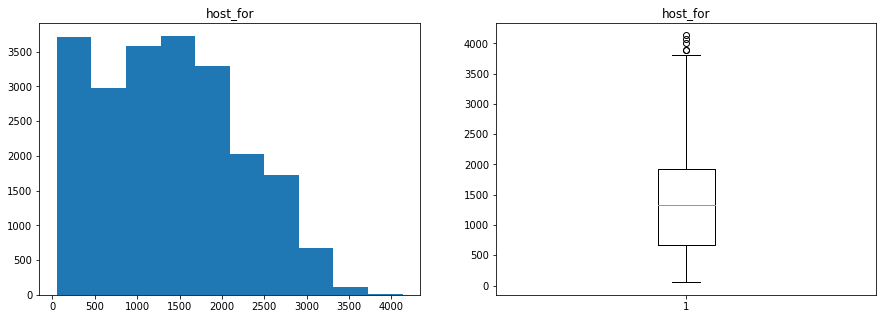

In [26]:
plt.figure(figsize=[15,5])
x = df['host_for']

plt.subplot(121)
plt.hist(x)
plt.title("host_for")

plt.subplot(122)
plt.boxplot(x)
plt.title("host_for")
plt.show()

Conclusions:
- The distribution is right-skewed
- There are some outliers in the upper-bound, but they are worth keeping as it makes sense that there are people that have been hosting in Airbnb for longer than others, and this variable will keep increasing over time.

## Host_response_time

In [27]:
df.host_response_time.value_counts()

within an hour        12980
within a few hours     2363
within a day           1391
a few days or more      381
Name: host_response_time, dtype: int64

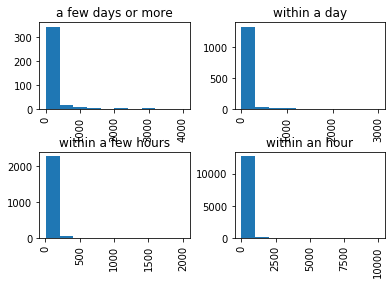

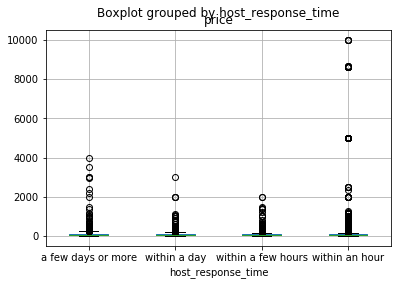

In [28]:
df.hist(column='price', by='host_response_time')
df.boxplot(column='price', by='host_response_time',return_type=None)

In [29]:
df.host_response_time.isna().sum()

4718

We have 4718 missing values.

We will use it the randomized imputation because we cannot deduct behaviours and we want to keep the distribution shape.

In [30]:
def randomiseMissingData(df2, col):
    df = df2.copy()
    data = df[col]
    mask = data.isnull()
    samples = random.choices( data[~mask].values , k = mask.sum() )
    data[mask] = samples
    return df

In [31]:
df = randomiseMissingData(df,"host_response_time")

In [32]:
df.host_response_time.isna().sum()

0

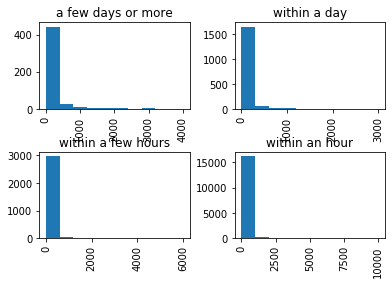

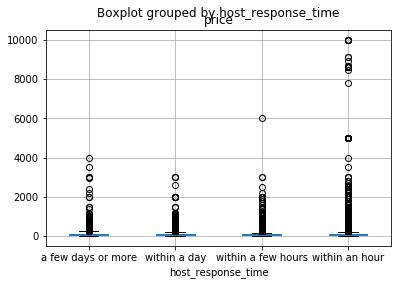

In [33]:
df.hist(column='price', by='host_response_time')
df.boxplot(column='price', by='host_response_time',return_type=None)

## Host_response_rate

In [34]:
df.host_response_rate.value_counts()

100%    11673
90%       739
99%       581
98%       569
97%       560
        ...  
36%         1
10%         1
62%         1
42%         1
29%         1
Name: host_response_rate, Length: 65, dtype: int64

In [35]:
df.host_response_rate = df.host_response_rate.str.replace('%','')

In [36]:
df['host_response_rate']=pd.to_numeric(df['host_response_rate'])

Text(0.5, 1.0, 'host_response_rate')

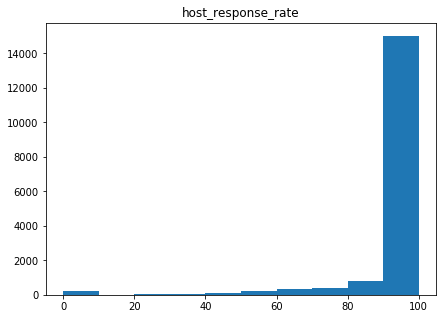

In [37]:
plt.figure(figsize=[7,5])
plt.hist(df['host_response_rate'])
plt.title("host_response_rate")

In [38]:
df.host_response_rate.isna().sum()

4718

We have 4718 missing values.

We will use it the randomized imputation because we cannot deduct behaviours and we want to keep the distribution shape.

In [39]:
def randomiseMissingData(df2, col):
    df = df2.copy()
    data = df[col]
    mask = data.isnull()
    samples = random.choices( data[~mask].values , k = mask.sum() )
    data[mask] = samples
    return df

In [40]:
df = randomiseMissingData(df,"host_response_rate")

In [41]:
df.host_response_rate.isna().sum()

0

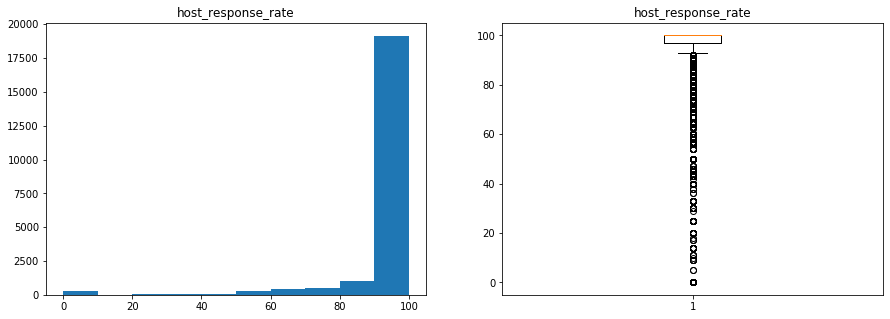

In [42]:
plt.figure(figsize=[15,5])
x = df['host_response_rate']

plt.subplot(121)
plt.hist(x)
plt.title("host_response_rate")

plt.subplot(122)
plt.boxplot(x)
plt.title("host_response_rate")
plt.show()

In [43]:
df['host_response_rate'].describe()

count    21833.000000
mean        94.541703
std         15.105044
min          0.000000
25%         97.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: host_response_rate, dtype: float64

Keeping the percentages would not be as valuable as having them binned.

In [44]:
df.host_response_rate [(df.host_response_rate <= 25)] = 1
df.host_response_rate [(df.host_response_rate > 25) & (df.host_response_rate <= 50)] = 2
df.host_response_rate [(df.host_response_rate > 50) & (df.host_response_rate <= 75)] = 3
df.host_response_rate [(df.host_response_rate > 75)] = 4

In [45]:
df['host_response_rate'].value_counts()

4.0    20337
3.0      796
2.0      364
1.0      336
Name: host_response_rate, dtype: int64

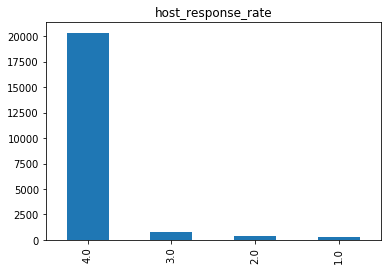

In [46]:
df['host_response_rate'].value_counts().plot(kind='bar', title='host_response_rate')

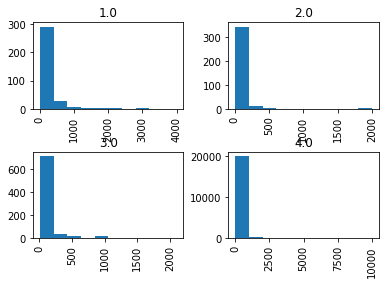

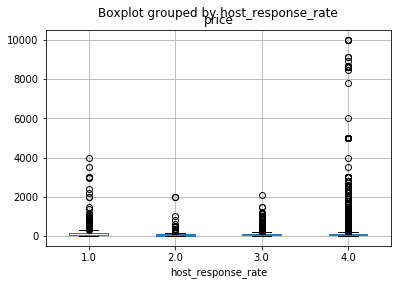

In [47]:
df.hist(column='price', by='host_response_rate')
df.boxplot(column='price', by='host_response_rate')

## Host_acceptance_rate

In [48]:
df.host_acceptance_rate.value_counts()

100%    8457
99%     1655
98%     1105
97%      695
96%      497
        ... 
7%         4
51%        3
4%         2
26%        2
12%        2
Name: host_acceptance_rate, Length: 98, dtype: int64

In [49]:
df.host_acceptance_rate = df.host_acceptance_rate.str.replace('%','')

In [50]:
df['host_acceptance_rate']=pd.to_numeric(df['host_acceptance_rate'])

Text(0.5, 1.0, 'host_acceptance_rate')

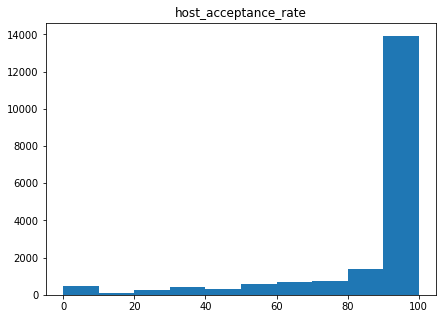

In [51]:
plt.figure(figsize=[7,5])
plt.hist(df['host_acceptance_rate'])
plt.title("host_acceptance_rate")

In [52]:
df.host_acceptance_rate.isna().sum()

3025

We have 3025 missing values.

We will use it the randomized imputation because we cannot deduct behaviours and we want to keep the distribution shape.

In [53]:
def randomiseMissingData(df2, col):
    df = df2.copy()
    data = df[col]
    mask = data.isnull()
    samples = random.choices( data[~mask].values , k = mask.sum() )
    data[mask] = samples
    return df

In [54]:
df = randomiseMissingData(df,"host_acceptance_rate")

In [55]:
df.host_acceptance_rate.isna().sum()

0

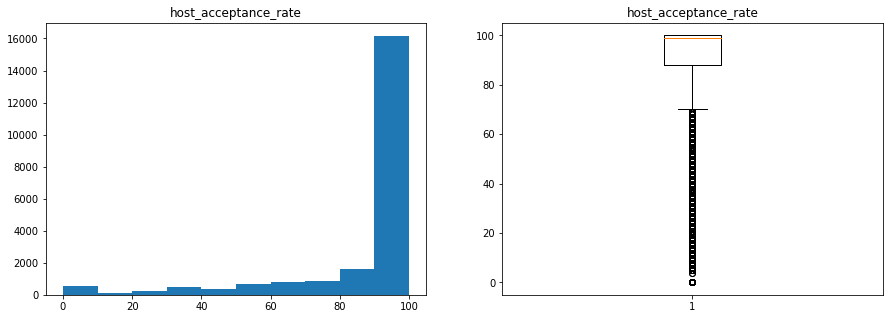

In [56]:
plt.figure(figsize=[15,5])
x = df['host_acceptance_rate']

plt.subplot(121)
plt.hist(x)
plt.title("host_acceptance_rate")

plt.subplot(122)
plt.boxplot(x)
plt.title("host_acceptance_rate")
plt.show()

In [57]:
df['host_acceptance_rate'].describe()

count    21833.000000
mean        87.959099
std         22.751284
min          0.000000
25%         88.000000
50%         99.000000
75%        100.000000
max        100.000000
Name: host_acceptance_rate, dtype: float64

Keeping the percentages would not be as valuable as having them binned.

In [58]:
df.host_acceptance_rate [(df.host_acceptance_rate <= 25)] = 1
df.host_acceptance_rate [(df.host_acceptance_rate > 25) & (df.host_acceptance_rate <= 50)] = 2
df.host_acceptance_rate [(df.host_acceptance_rate > 50) & (df.host_acceptance_rate <= 75)] = 3
df.host_acceptance_rate [(df.host_acceptance_rate > 75)] = 4

In [59]:
df['host_acceptance_rate'].value_counts()

4.0    18050
3.0     1683
2.0     1276
1.0      824
Name: host_acceptance_rate, dtype: int64

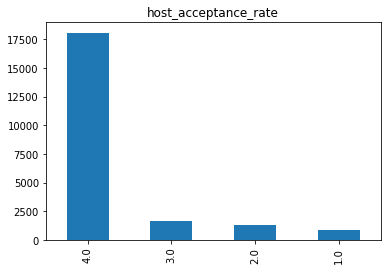

In [60]:
df['host_acceptance_rate'].value_counts().plot(kind='bar', title='host_acceptance_rate')

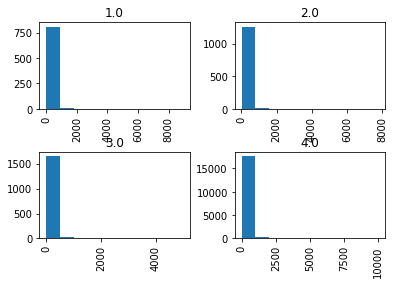

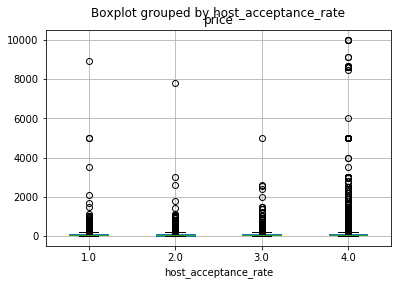

In [61]:
df.hist(column='price', by='host_acceptance_rate')
df.boxplot(column='price', by='host_acceptance_rate')

## Host_is_superhost

In [62]:
df.host_is_superhost.value_counts()

f    17515
t     4311
Name: host_is_superhost, dtype: int64

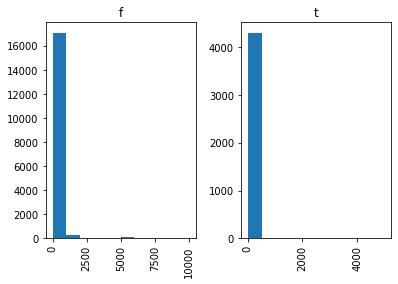

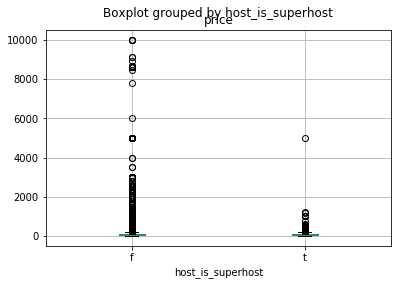

In [63]:
df.hist(column='price', by='host_is_superhost')
df.boxplot(column='price', by='host_is_superhost')

In [64]:
df.host_is_superhost.isna().sum()

7

There are 7 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [65]:
df.host_id[df.host_is_superhost.isnull()]

1972      36068881
2227      40516896
2543      46845753
3791      46959915
3857      46959915
11165     46959915
20701    142589414
Name: host_id, dtype: int64

In [66]:
df.host_is_superhost[df['host_id'] == 36068881] = "f"
df.host_is_superhost[df['host_id'] == 40516896] = "f"
df.host_is_superhost[df['host_id'] == 46845753] = "f"
df.host_is_superhost[df['host_id'] == 46959915] = "t"
df.host_is_superhost[df['host_id'] == 142589414] = "f"

In [67]:
df.host_is_superhost.isna().sum()

0

In [68]:
#replacing trues for 1 and false with 0
df.host_is_superhost = df.host_is_superhost.replace('t',1)
df.host_is_superhost = df.host_is_superhost.replace('f',0)

In [69]:
df.host_is_superhost.value_counts()

0    17519
1     4314
Name: host_is_superhost, dtype: int64

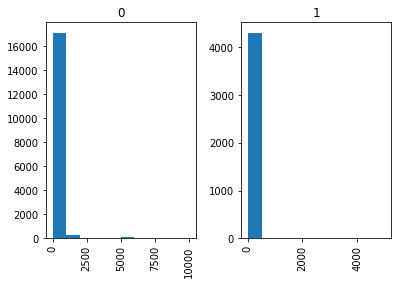

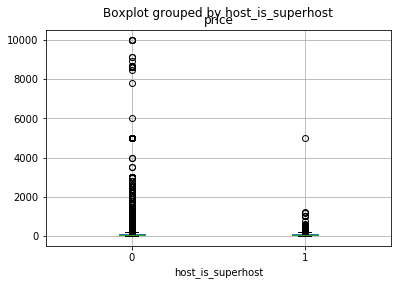

In [70]:
df.hist(column='price', by='host_is_superhost')
df.boxplot(column='price', by='host_is_superhost')

Conclusions:
- There are many less superhosts than superhosts, meaning it's special to be a superhost.

# Host_listings_count

In [71]:
df.host_listings_count.describe()

count    21826.000000
mean        16.596216
std         61.027599
min          0.000000
25%          1.000000
50%          2.000000
75%          7.000000
max        527.000000
Name: host_listings_count, dtype: float64

Text(0.5, 1.0, 'host_listings_count')

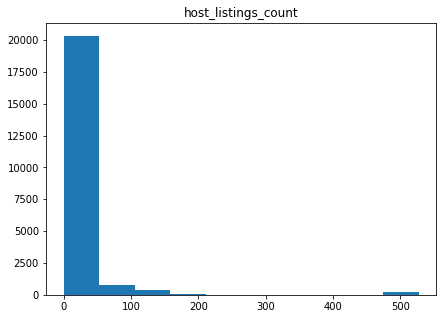

In [72]:
plt.figure(figsize=[7,5])
plt.hist(df['host_listings_count'])
plt.title("host_listings_count")

In [73]:
df.host_listings_count.isna().sum()

7

There are 7 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [74]:
df.host_id[df.host_listings_count.isnull()]

1972      36068881
2227      40516896
2543      46845753
3791      46959915
3857      46959915
11165     46959915
20701    142589414
Name: host_id, dtype: int64

In [75]:
df.host_listings_count[df['host_id'] == 36068881] = 1
df.host_listings_count[df['host_id'] == 40516896] = 1
df.host_listings_count[df['host_id'] == 46845753] = 1
df.host_listings_count[df['host_id'] == 46959915] = 3
df.host_listings_count[df['host_id'] == 142589414] = 1

In [76]:
df.host_listings_count.isna().sum()

0

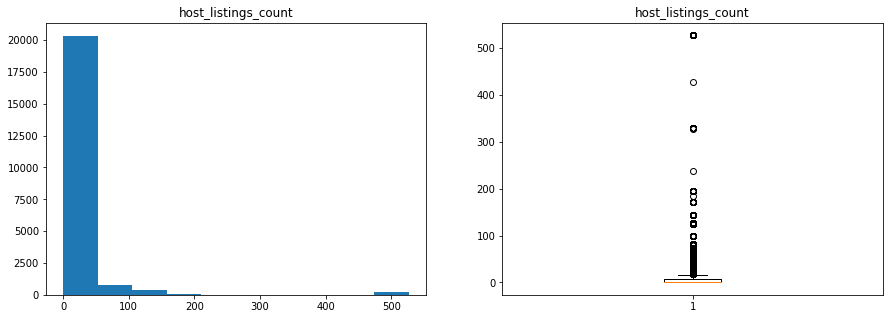

In [77]:
plt.figure(figsize=[15,5])
x = df['host_listings_count']

plt.subplot(121)
plt.hist(x)
plt.title("host_listings_count")

plt.subplot(122)
plt.boxplot(x)
plt.title("host_listings_count")
plt.show()

Conclusions:
- The distribution is right skewed, imputedwith median.
- There are a lot of outliers in the upperbound.

# Host_verifications

In [78]:
df.host_verifications.value_counts()

['email', 'phone']                                                                                                      3045
['email', 'phone', 'reviews', 'jumio', 'government_id']                                                                 1759
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']                      1718
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']           1658
['email', 'phone', 'reviews']                                                                                           1419
                                                                                                                        ... 
['email', 'phone', 'manual_online', 'reviews', 'manual_offline', 'jumio', 'government_id', 'work_email']                   1
['email', 'phone', 'facebook', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'work_email']       1


In [79]:
df.host_verifications.isna().sum()

0

As we can see, the variable is prettty messy. Therefore, we will create a list with all the possible options for the variable, and from there, create dummies based on groups.

In [80]:
verification_list = list(df.host_verifications)
verification_list_string = " ".join(verification_list)
verification_list_string = verification_list_string.replace('[', '')
verification_list_string = verification_list_string.replace(']', ',')
verification_list_string = verification_list_string.replace('"', '')
verification_set = [x.strip() for x in verification_list_string.split(',')]
verification_set = set(verification_set)
verification_set

{'',
 "'email'",
 "'facebook'",
 "'google'",
 "'government_id'",
 "'identity_manual'",
 "'jumio'",
 "'kba'",
 "'manual_offline'",
 "'manual_online'",
 "'offline_government_id'",
 "'phone'",
 "'reviews'",
 "'selfie'",
 "'sent_id'",
 "'sesame'",
 "'sesame_offline'",
 "'weibo'",
 "'work_email'",
 "'zhima_selfie'",
 "None 'email'"}

In [81]:
df.loc[df['host_verifications'].str.contains('email|work_email'), 'email'] = 1
df.loc[df['host_verifications'].str.contains('facebook'), 'facebook'] = 1
df.loc[df['host_verifications'].str.contains('google'), 'google'] = 1
df.loc[df['host_verifications'].str.contains('government_id|offline_government_id'), 'government'] = 1
df.loc[df['host_verifications'].str.contains('jumio|kba|zhima_selfie|sesame|sesame_offline|weibo'), 'external_verifications'] = 1
df.loc[df['host_verifications'].str.contains('identity_manual|manual_offline|manual_online'), 'manual'] = 1
df.loc[df['host_verifications'].str.contains('phone'), 'phone'] = 1
df.loc[df['host_verifications'].str.contains('reviews'), 'reviews'] = 1
df.loc[df['host_verifications'].str.contains('selfie'), 'selfie'] = 1
df.loc[df['host_verifications'].str.contains('sent_id'), 'sent_id'] = 1
df.loc[df['host_verifications'].str.contains('phone'), 'phone'] = 1

In [82]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,-11:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

In [83]:
# Dropping the original host_verifications feature, as we have extracted all the information we needed from it.
df.drop('host_verifications', axis=1, inplace=True)

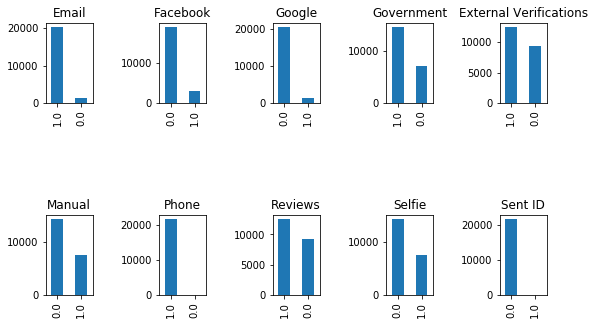

In [84]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=3, ncols=10)
ax0 = fig.add_subplot(gs[0, 0])
ax0 = df['email'].value_counts().plot(kind='bar', title='Email')
ax1 = fig.add_subplot(gs[0, 2])
ax1 = df['facebook'].value_counts().plot(kind='bar', title='Facebook')
ax2 = fig.add_subplot(gs[0, 4])
ax2 = df['google'].value_counts().plot(kind='bar', title='Google')
ax3 = fig.add_subplot(gs[0, 6])
ax3 = df['government'].value_counts().plot(kind='bar', title='Government')
ax4 = fig.add_subplot(gs[0, 8])
ax4 = df['external_verifications'].value_counts().plot(kind='bar', title='External Verifications')
ax5 = fig.add_subplot(gs[2, 0])
ax5 = df['manual'].value_counts().plot(kind='bar', title='Manual')
ax6 = fig.add_subplot(gs[2, 2])
ax6 = df['phone'].value_counts().plot(kind='bar', title='Phone')
ax7 = fig.add_subplot(gs[2, 4])
ax7 = df['reviews'].value_counts().plot(kind='bar', title='Reviews')
ax8 = fig.add_subplot(gs[2, 6])
ax8 = df['selfie'].value_counts().plot(kind='bar', title='Selfie')
ax9 = fig.add_subplot(gs[2, 8])
ax9 = df['sent_id'].value_counts().plot(kind='bar', title='Sent ID')
plt.show()

As it can be seen, half of the available options for host verifications are used by the hosts for our listings. The other half are not as commonly used by our hosts. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123aeba10>,
      dtype=object)

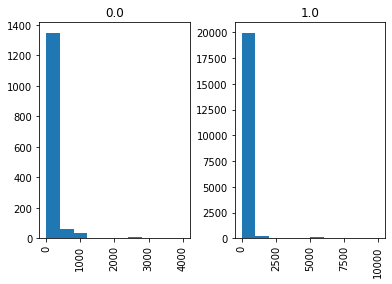

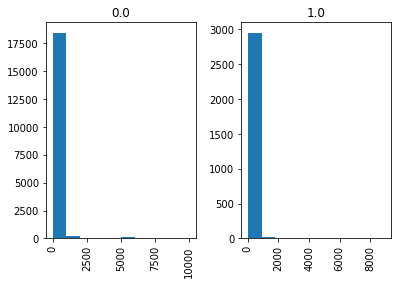

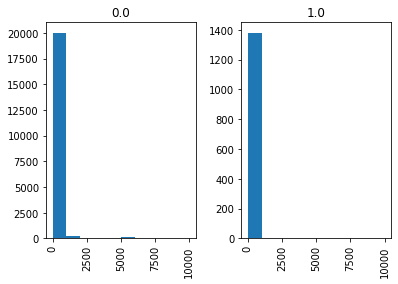

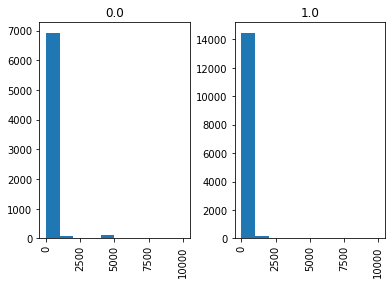

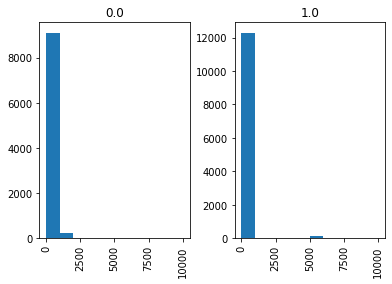

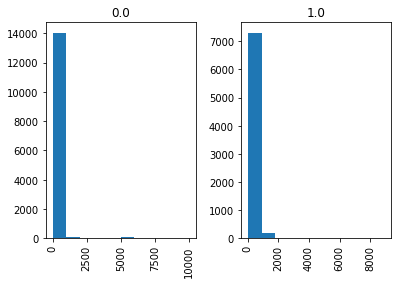

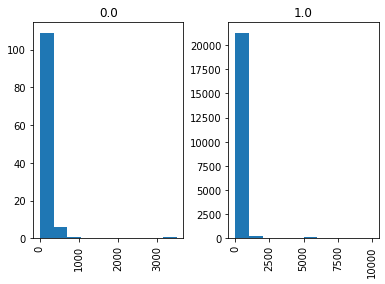

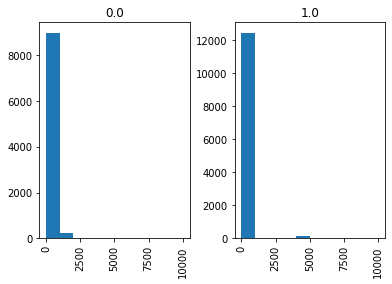

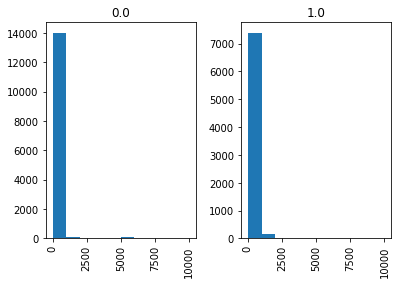

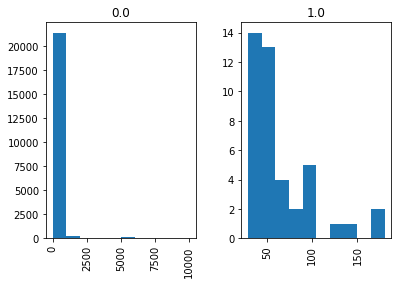

In [85]:
df.hist(column='price', by='email')
df.hist(column='price', by='facebook')
df.hist(column='price', by='google')
df.hist(column='price', by='government')
df.hist(column='price', by='external_verifications')
df.hist(column='price', by='manual')
df.hist(column='price', by='phone')
df.hist(column='price', by='reviews')
df.hist(column='price', by='selfie')
df.hist(column='price', by='sent_id')

By looking at the histograms for all of these options for hosts to verify and comparing them with price we can see that they are all right skewed.

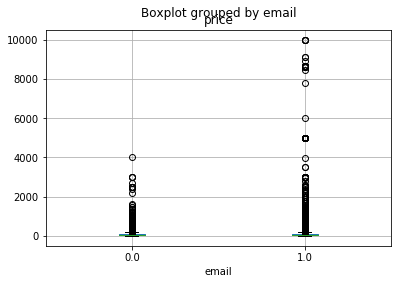

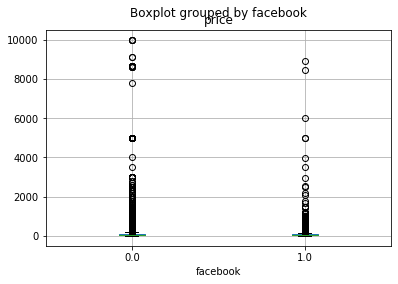

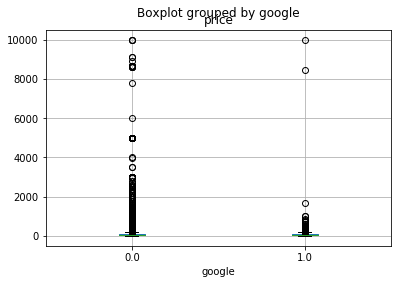

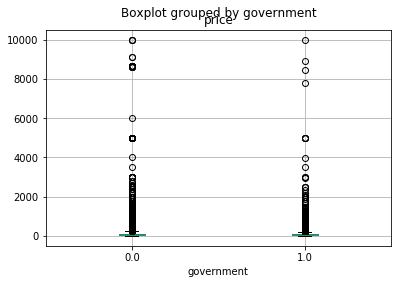

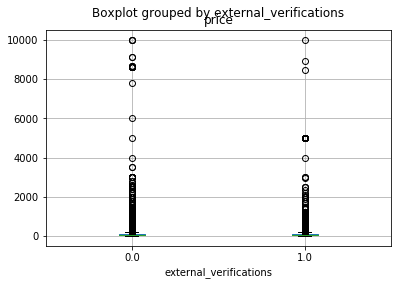

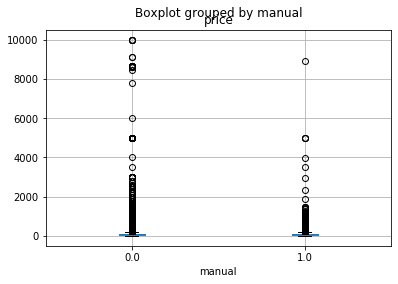

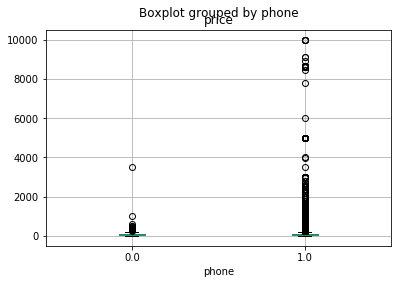

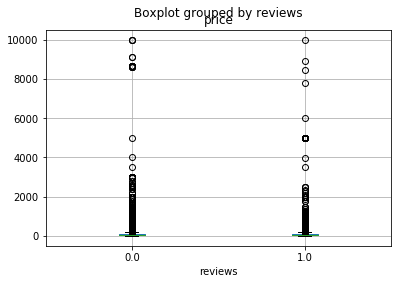

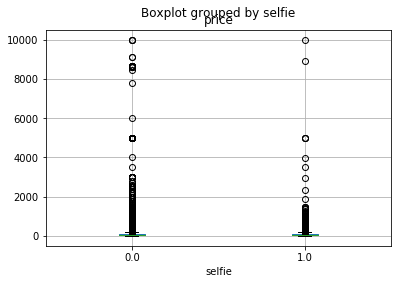

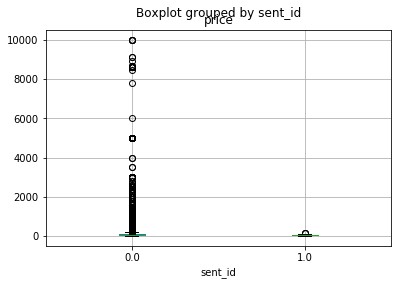

In [86]:
df.boxplot(column='price', by='email')
df.boxplot(column='price', by='facebook')
df.boxplot(column='price', by='google')
df.boxplot(column='price', by='government')
df.boxplot(column='price', by='external_verifications')
df.boxplot(column='price', by='manual')
df.boxplot(column='price', by='phone')
df.boxplot(column='price', by='reviews')
df.boxplot(column='price', by='selfie')
df.boxplot(column='price', by='sent_id')

From looking at the outliers we can see that all of the options have upper bound outliers.

# Host_has_profile_pic

In [87]:
df.host_has_profile_pic.value_counts()

t    21781
f       45
Name: host_has_profile_pic, dtype: int64

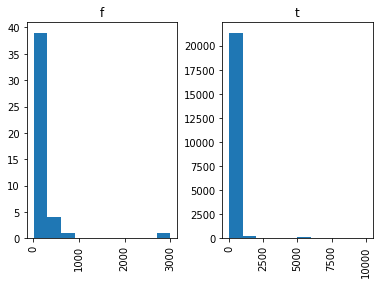

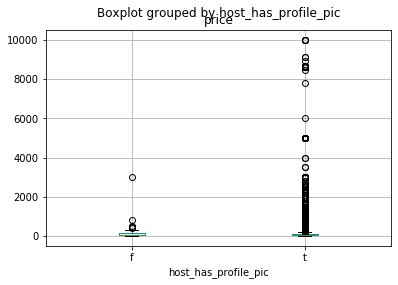

In [88]:
df.hist(column='price', by='host_has_profile_pic')
df.boxplot(column='price', by='host_has_profile_pic')

In [89]:
df.host_has_profile_pic.isna().sum()

7

There are 7 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [90]:
df.host_id[df.host_has_profile_pic.isnull()]

1972      36068881
2227      40516896
2543      46845753
3791      46959915
3857      46959915
11165     46959915
20701    142589414
Name: host_id, dtype: int64

In [91]:
df.host_has_profile_pic[df['host_id'] == 36068881] = "t"
df.host_has_profile_pic[df['host_id'] == 40516896] = "t"
df.host_has_profile_pic[df['host_id'] == 46845753] = "t"
df.host_has_profile_pic[df['host_id'] == 46959915] = "t"
df.host_has_profile_pic[df['host_id'] == 142589414] = "t"

In [92]:
df.host_has_profile_pic.isna().sum()

0

In [93]:
#replacing trues for 1 and false with 0
df.host_has_profile_pic = df.host_has_profile_pic.replace('t',1)
df.host_has_profile_pic = df.host_has_profile_pic.replace('f',0)

In [94]:
df.host_has_profile_pic.value_counts()

1    21788
0       45
Name: host_has_profile_pic, dtype: int64

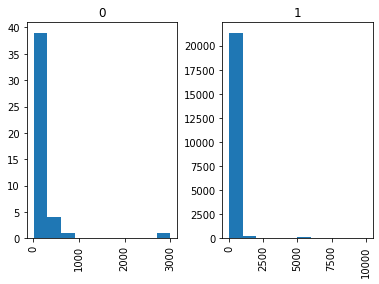

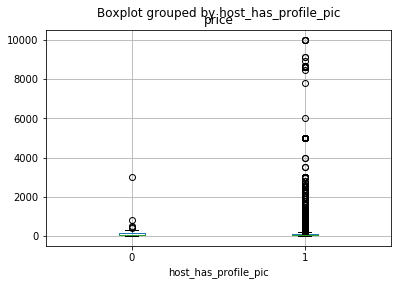

In [95]:
df.hist(column='price', by='host_has_profile_pic')
df.boxplot(column='price', by='host_has_profile_pic')

Conclusion:
- There are significantly more hosts with profile pictures than without.

# Host_identity_verified

In [96]:
df.host_identity_verified.value_counts()

f    15607
t     6219
Name: host_identity_verified, dtype: int64

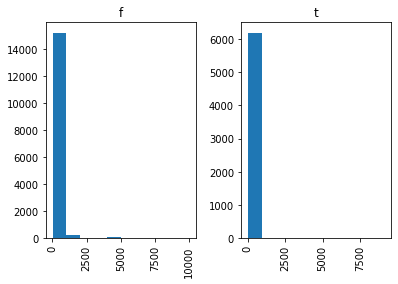

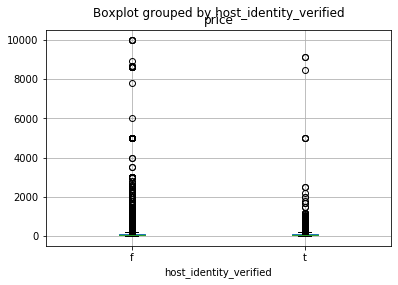

In [97]:
df.hist(column='price', by='host_identity_verified')
df.boxplot(column='price', by='host_identity_verified')

In [98]:
df.host_identity_verified.isna().sum()

7

There are 7 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [99]:
df.host_id[df.host_identity_verified.isnull()]

1972      36068881
2227      40516896
2543      46845753
3791      46959915
3857      46959915
11165     46959915
20701    142589414
Name: host_id, dtype: int64

In [100]:
df.host_identity_verified[df['host_id'] == 36068881] = "f"
df.host_identity_verified[df['host_id'] == 40516896] = "f"
df.host_identity_verified[df['host_id'] == 46845753] = "f"
df.host_identity_verified[df['host_id'] == 46959915] = "t"
df.host_identity_verified[df['host_id'] == 142589414] = "t"

In [101]:
df.host_identity_verified.isna().sum()

0

In [102]:
#replacing trues for 1 and false with 0
df.host_identity_verified = df.host_identity_verified.replace('t',1)
df.host_identity_verified = df.host_identity_verified.replace('f',0)

In [103]:
df.host_identity_verified.value_counts()

0    15610
1     6223
Name: host_identity_verified, dtype: int64

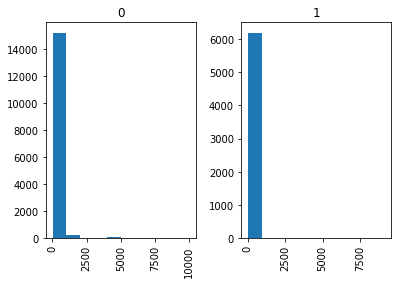

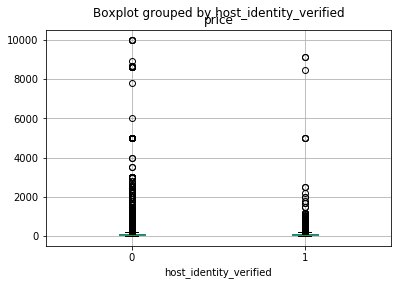

In [104]:
df.hist(column='price', by='host_identity_verified')
df.boxplot(column='price', by='host_identity_verified')

Conclusion
- The majority of hosts aren't verified.

## Neighborhood variables

In [105]:
neighborhoods_vbles = ['neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'city','host_location',\
                       'host_neighbourhood', 'state', 'zipcode', 'smart_location','street','market','country_code','country']

In [106]:
for vble in neighborhoods_vbles:
  print('\n-----{0}-----'.format(vble))
  print(df[vble].value_counts())


-----neighbourhood-----
Centro            5033
Embajadores       1224
Malasaña           889
Salamanca          730
Carabanchel        713
                  ... 
Castilla            25
Nueva España        24
El Tréntaiseis      19
Estrella            19
Atocha              12
Name: neighbourhood, Length: 66, dtype: int64

-----neighbourhood_cleansed-----
Embajadores      2775
Universidad      2131
Palacio          1597
Sol              1409
Justicia         1187
                 ... 
Pavones             6
Valdemarín          5
El Pardo            4
Horcajo             3
Fuentelareina       3
Name: neighbourhood_cleansed, Length: 127, dtype: int64

-----neighbourhood_group_cleansed-----
Centro                   10113
Salamanca                 1429
Chamberí                  1286
Arganzuela                1216
Tetuán                     898
Carabanchel                710
Ciudad Lineal              685
Retiro                     673
Puente de Vallecas         670
Latina                   

We can see that:

- `'neighbourhood'`,`'neighbourhood_cleansed'`,`'neighbourhood_group_cleansed'`,`'city'`,`'smart_location'` & `'street'`: is all very messy and incoherent between them. Refer to the next session to see how have we decided to treat this information.
- `'host_location'` & `'host_neighbourhood'`: does not relate to the house price
- `'state'`: is all referring to Madrid
- `'zipcode'` & `'market'`: do not give much information
- `'country_code'`: is all 'Spain'
- `'country'`: is all 'Spain'

For the reasons showed above, we will drop these variables.

In [107]:
df = df.drop(neighborhoods_vbles,axis=1)

## Latitude and Longitude

In [108]:
df.latitude.isna().sum()

0

In [109]:
df.longitude.isna().sum()

0

In [110]:
# Please run this code if you do not have the library installed
#! pip install reverse_geocoder

In [111]:
import reverse_geocoder as rg
coords = zip(df["latitude"],df["longitude"])
df["Coordinatestuple"] = list(coords)
listofareas = rg.search(list(np.unique(df["Coordinatestuple"])))
listofareas = list(map(lambda x: x["name"],listofareas))
areadict = dict(zip(list(np.unique(df["Coordinatestuple"])),listofareas))
df["area_name"] = df.Coordinatestuple.apply(lambda x: areadict[x])

Loading formatted geocoded file...


In [112]:
df.area_name.value_counts()

Madrid                     5327
City Center                4106
Chamberi                   2201
Salamanca                  1605
Arganzuela                 1292
Puente de Vallecas          757
Carabanchel                 726
Tetuan de las Victorias     675
Retiro                      646
Latina                      609
Moratalaz                   575
Chamartin                   557
San Blas                    514
Usera                       496
Ciudad Lineal               328
Moncloa-Aravaca             229
Villaverde                  219
Barajas de Madrid           216
Hortaleza                   174
Pinar de Chamartin          164
Villa de Vallecas           102
Las Tablas                   90
Vicalvaro                    58
Fuencarral-El Pardo          57
Coslada                      52
Pozuelo de Alarcon           39
Leganes                       5
El Pardo                      5
Las Matas                     2
Majadahonda                   2
San Fernando de Henares       2
Alcorcon

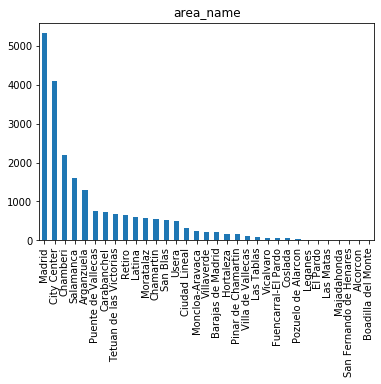

In [113]:
df['area_name'].value_counts().plot(kind='bar', title='area_name')

Now, we no longer need the `'Coordinatestuple'`, `'Latitud'` & `'Longitud'`variables.

In [114]:
df = df.drop(['Coordinatestuple','latitude','longitude'], axis=1)

# Room_type

In [115]:
df.room_type.value_counts()

Entire home/apt    13294
Private room        7924
Shared room          340
Hotel room           275
Name: room_type, dtype: int64

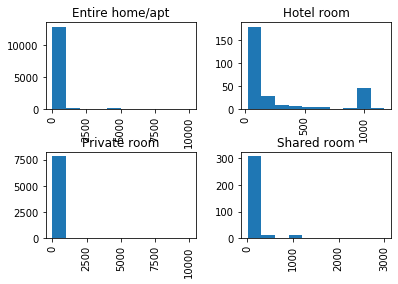

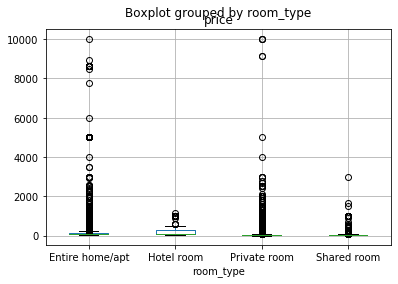

In [116]:
df.hist(column='price', by='room_type')
df.boxplot(column='price', by='room_type')

In [117]:
df.room_type.isna().sum()

0

Conclusions:
- Entire home/apartment is the most common
- 4 categories

# Accommodates

In [118]:
df.accommodates.describe()

count    21833.000000
mean         3.286127
std          2.019686
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         20.000000
Name: accommodates, dtype: float64

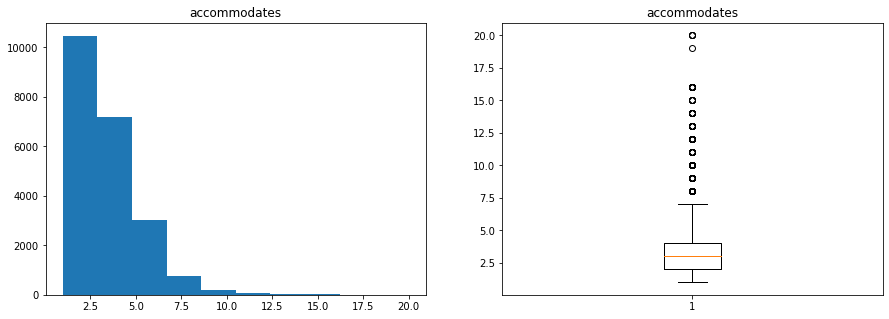

In [119]:
plt.figure(figsize=[15,5])
x = df['accommodates']

plt.subplot(121)
plt.hist(x)
plt.title("accommodates")

plt.subplot(122)
plt.boxplot(x)
plt.title("accommodates")
plt.show()

In [120]:
df.accommodates.isna().sum()

0

Conclusions:
- Distribution is right-skewed
- Many outliers in the upperbound
- Maybe we could group by percentiles

# Bathrooms

In [121]:
df.bathrooms.describe()

count    21824.000000
mean         1.297883
std          0.733069
min          0.000000
25%          1.000000
50%          1.000000
75%          1.500000
max         12.000000
Name: bathrooms, dtype: float64

Text(0.5, 1.0, 'bathrooms')

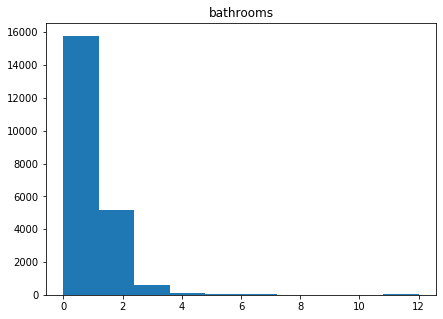

In [122]:
plt.figure(figsize=[7,5])
plt.hist(df['bathrooms'])
plt.title("bathrooms")

In [123]:
df.bathrooms.isna().sum()

9

There are 9 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [124]:
df.id[df.bathrooms.isnull()]

58         183435
76         229664
200        536574
203        541406
281        691458
365        814647
526       1126038
569       1254418
19225    40028818
Name: id, dtype: int64

In [125]:
df.bathrooms[df['id'] == 183435] = 2
df.bathrooms[df['id'] == 229664] = 2
df.bathrooms[df['id'] == 536574] = 2
df.bathrooms[df['id'] == 691458] = 1
df.bathrooms[df['id'] == 814647] = 1
df.bathrooms[df['id'] == 1126038] = 1
df.bathrooms[df['id'] == 1254418] = 1
df.bathrooms[df['id'] == 40028818] = 1

For this particular case, the information of the Airbnb website is not representative, as the pictures of the house do not give any hint on the number of bathrooms.

Thus, as the distribution is skewed, we will impute it with the mode.

In [126]:
df.bathrooms[df['id'] == 541406] = df.bathrooms.mode()[0]

In [127]:
df.bathrooms.isna().sum()

0

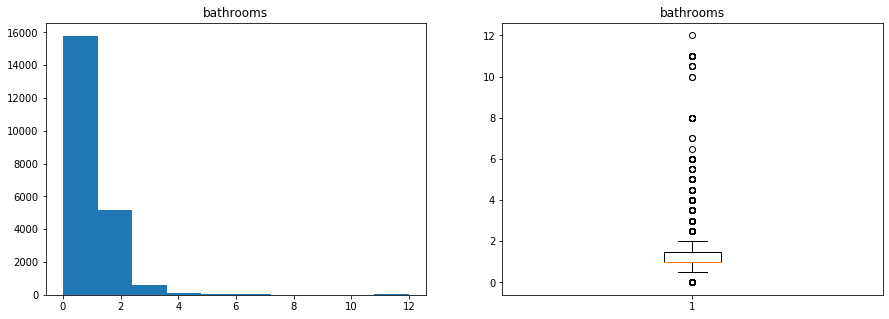

In [128]:
plt.figure(figsize=[15,5])
x = df['bathrooms']

plt.subplot(121)
plt.hist(x)
plt.title("bathrooms")

plt.subplot(122)
plt.boxplot(x)
plt.title("bathrooms")
plt.show()

Conclusion:
- Distribution is right-skewed.
- Many outliers in both bounds, but mainly in upper.

# Bedrooms

In [129]:
df.bedrooms.describe()

count    21815.000000
mean         1.347101
std          0.853314
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
Name: bedrooms, dtype: float64

Text(0.5, 1.0, 'bedrooms')

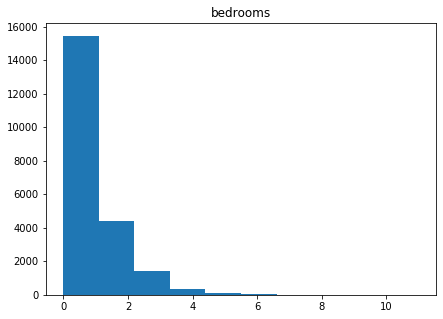

In [130]:
plt.figure(figsize=[7,5])
plt.hist(df['bedrooms'])
plt.title("bedrooms")

In [131]:
df.bedrooms.isna().sum()

18

There are 18 missing values.

We impute them by exploring each case relying on the URLs available in the dataset.

In [132]:
df.id[df.bedrooms.isnull()]

12051    29759741
17997    38408337
18524    39216903
18550    39244106
18708    39463645
18832    39628400
18981    39813692
18988    39828588
19257    40072518
19316    40114350
19430    40190101
19510    40254034
19824    40533219
20709    41406063
20936    41630214
20970    41665580
21745    42271892
21795    42321148
Name: id, dtype: int64

In [133]:
df.bedrooms[df['id'] == 29759741] = 1
df.bedrooms[df['id'] == 38408337] = 1
df.bedrooms[df['id'] == 39216903] = 1
df.bedrooms[df['id'] == 39244106] = 1
df.bedrooms[df['id'] == 39463645] = 1
df.bedrooms[df['id'] == 39628400] = 1
df.bedrooms[df['id'] == 39813692] = 1
df.bedrooms[df['id'] == 39828588] = 1
df.bedrooms[df['id'] == 40072518] = 1
df.bedrooms[df['id'] == 40114350] = 1
df.bedrooms[df['id'] == 40190101] = 1
df.bedrooms[df['id'] == 40254034] = 1
df.bedrooms[df['id'] == 40533219] = 1
df.bedrooms[df['id'] == 41406063] = 1
df.bedrooms[df['id'] == 41630214] = 1
df.bedrooms[df['id'] == 41665580] = 1
df.bedrooms[df['id'] == 42271892] = 1
df.bedrooms[df['id'] == 42321148] = 1

In [134]:
df.bedrooms.isna().sum()

0

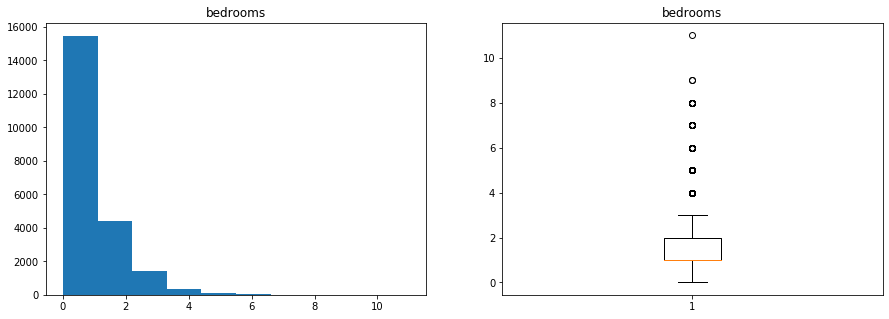

In [135]:
plt.figure(figsize=[15,5])
x = df['bedrooms']

plt.subplot(121)
plt.hist(x)
plt.title("bedrooms")

plt.subplot(122)
plt.boxplot(x)
plt.title("bedrooms")
plt.show()

Conclusions:
- Distribution is right-skewed.
- Many outliers in upper-bound.

# Beds

In [136]:
df.beds.describe()

count    21625.000000
mean         1.994127
std          1.552870
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         50.000000
Name: beds, dtype: float64

Text(0.5, 1.0, 'beds')

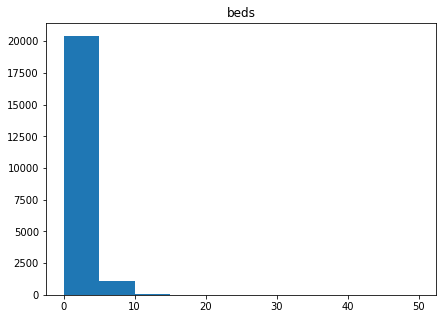

In [137]:
plt.figure(figsize=[7,5])
plt.hist(df['beds'])
plt.title("beds")

In [138]:
df.beds.isna().sum()

208

We have 208 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [139]:
df.beds.fillna(df.beds.mode()[0], inplace=True)

In [140]:
df.beds.isna().sum()

0

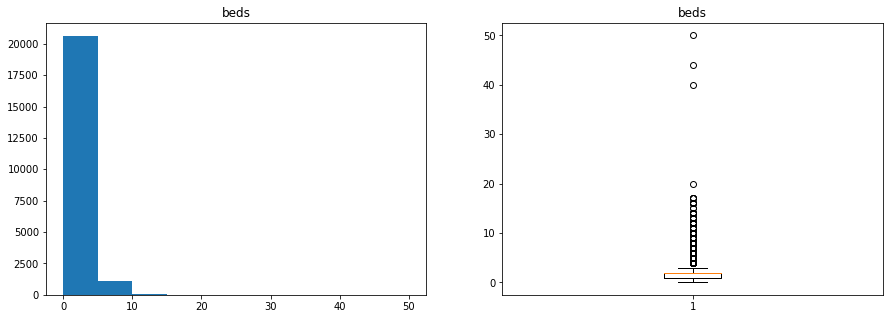

In [141]:
plt.figure(figsize=[15,5])
x = df['beds']

plt.subplot(121)
plt.hist(x)
plt.title("beds")

plt.subplot(122)
plt.boxplot(x)
plt.title("beds")
plt.show()

Conclusions:
- It is skewed to the right.
- Many outliers in the upper-bound.

# Bed_type

In [142]:
df.bed_type.value_counts()

Real Bed         21671
Pull-out Sofa      138
Futon               15
Couch                6
Airbed               3
Name: bed_type, dtype: int64

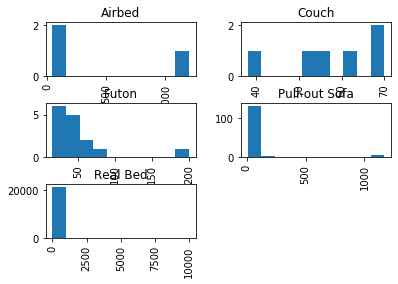

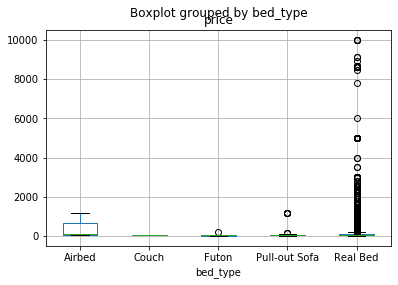

In [143]:
df.hist(column='price', by='bed_type')
df.boxplot(column='price', by='bed_type')

In [144]:
df.bed_type.isna().sum()

0

Conclusions:
- The most common are real beds, the rest aren't as common
- From experience a lot of Airbnbs have other types of beds, but maybe pull-out-sofa means that they only have that and no real bed.

# Amenities

In [145]:
df.amenities.value_counts()

{TV,Wifi,"Air conditioning",Kitchen,Elevator,Heating,Washer,Essentials,"Hair dryer",Iron}                                                                                                                                                                                                                                                                                                                                                          93
{}                                                                                                                                                                                                                                                                                                                                                                                                                                                 45
{TV,Wifi,"Air conditioning",Kitchen,Elevator,Heating,Washer,Dryer,Essentials,"Hair dryer",Iron}                             

In [146]:
df.amenities.isna().sum()

0

As we can see, the variable is prettty messy. Therefore, we will create a list with all the possible options for the variable, and from there, create dummies based on groups.

In [147]:
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Elevator',
 'En suite bathroom',
 'Espre

In [148]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [149]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,-28:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

In [150]:
# Dropping the original amenities feature, as we have already extracted the information we needed.
df.drop('amenities', axis=1, inplace=True)

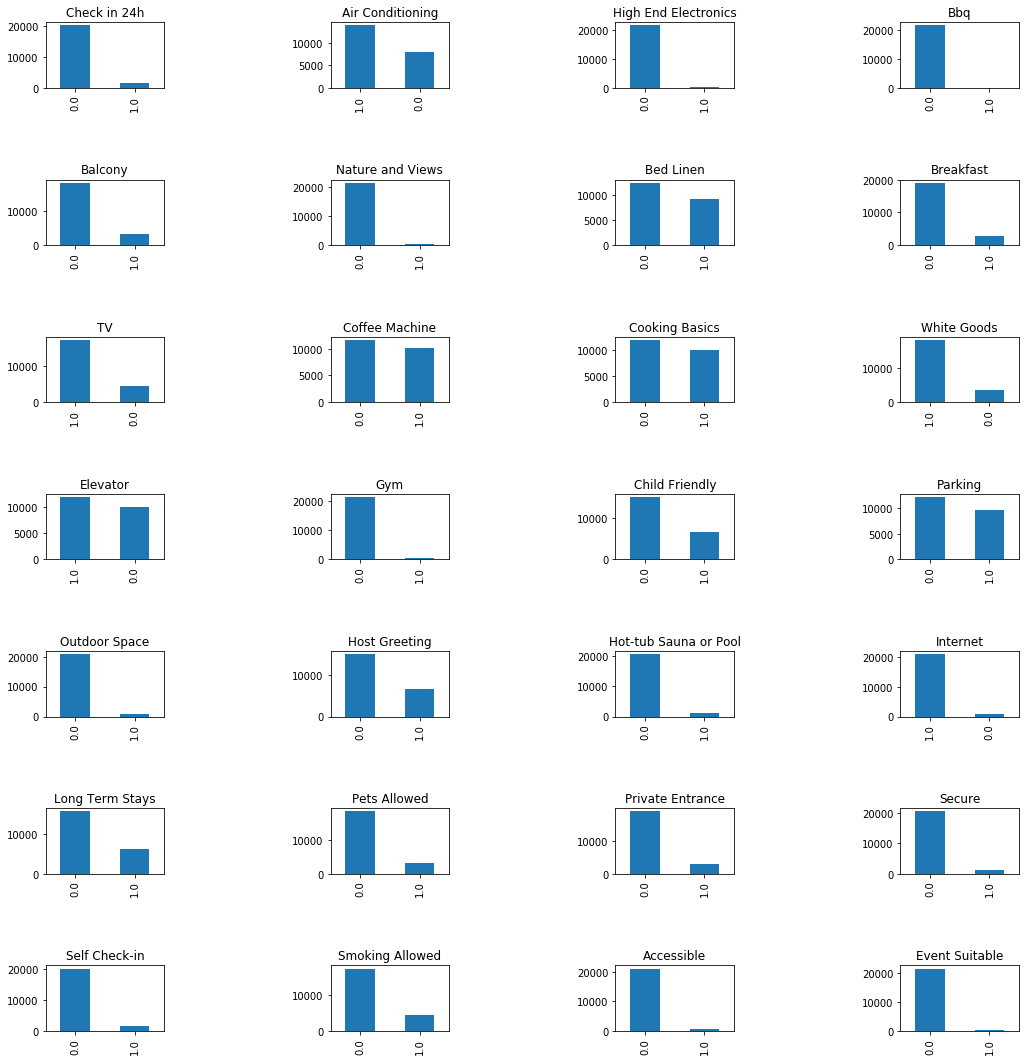

In [151]:
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(nrows=14, ncols=8)
ax0 = fig.add_subplot(gs[0, 0])
ax0 = df['check_in_24h'].value_counts().plot(kind='bar', title='Check in 24h')
ax1 = fig.add_subplot(gs[0, 2])
ax1 = df['air_conditioning'].value_counts().plot(kind='bar', title='Air Conditioning')
ax2 = fig.add_subplot(gs[0, 4])
ax2 = df['high_end_electronics'].value_counts().plot(kind='bar', title='High End Electronics')
ax3 = fig.add_subplot(gs[0, 6])
ax3 = df['bbq'].value_counts().plot(kind='bar', title='Bbq')
ax4 = fig.add_subplot(gs[2, 0])
ax4 = df['balcony'].value_counts().plot(kind='bar', title='Balcony')
ax5 = fig.add_subplot(gs[2, 2])
ax5 = df['nature_and_views'].value_counts().plot(kind='bar', title='Nature and Views')
ax6 = fig.add_subplot(gs[2, 4])
ax6 = df['bed_linen'].value_counts().plot(kind='bar', title='Bed Linen')
ax7 = fig.add_subplot(gs[2, 6])
ax7 = df['breakfast'].value_counts().plot(kind='bar', title='Breakfast')
ax8 = fig.add_subplot(gs[4, 0])
ax8 = df['tv'].value_counts().plot(kind='bar', title='TV')
ax9 = fig.add_subplot(gs[4, 2])
ax9 = df['coffee_machine'].value_counts().plot(kind='bar', title='Coffee Machine')
ax10 = fig.add_subplot(gs[4, 4])
ax10 = df['cooking_basics'].value_counts().plot(kind='bar', title='Cooking Basics')
ax11 = fig.add_subplot(gs[4, 6])
ax11 = df['white_goods'].value_counts().plot(kind='bar', title='White Goods')
ax12 = fig.add_subplot(gs[6, 0])
ax12 = df['elevator'].value_counts().plot(kind='bar', title='Elevator')
ax13 = fig.add_subplot(gs[6, 2])
ax13 = df['gym'].value_counts().plot(kind='bar', title='Gym')
ax14 = fig.add_subplot(gs[6, 4])
ax14 = df['child_friendly'].value_counts().plot(kind='bar', title='Child Friendly')
ax15 = fig.add_subplot(gs[6, 6])
ax15 = df['parking'].value_counts().plot(kind='bar', title='Parking')
ax16 = fig.add_subplot(gs[8, 0])
ax16 = df['outdoor_space'].value_counts().plot(kind='bar', title='Outdoor Space')
ax17 = fig.add_subplot(gs[8, 2])
ax17 = df['host_greeting'].value_counts().plot(kind='bar', title='Host Greeting')
ax18 = fig.add_subplot(gs[8, 4])
ax18 = df['hot_tub_sauna_or_pool'].value_counts().plot(kind='bar', title='Hot-tub Sauna or Pool')
ax19 = fig.add_subplot(gs[8, 6])
ax19 = df['internet'].value_counts().plot(kind='bar', title='Internet')
ax20 = fig.add_subplot(gs[10, 0])
ax20 = df['long_term_stays'].value_counts().plot(kind='bar', title='Long Term Stays')
ax21 = fig.add_subplot(gs[10, 2])
ax21 = df['pets_allowed'].value_counts().plot(kind='bar', title='Pets Allowed')
ax22 = fig.add_subplot(gs[10, 4])
ax22 = df['private_entrance'].value_counts().plot(kind='bar', title='Private Entrance')
ax23 = fig.add_subplot(gs[10, 6])
ax23 = df['secure'].value_counts().plot(kind='bar', title='Secure')
ax24 = fig.add_subplot(gs[12, 0])
ax24 = df['self_check_in'].value_counts().plot(kind='bar', title='Self Check-in')
ax25 = fig.add_subplot(gs[12, 2])
ax25 = df['smoking_allowed'].value_counts().plot(kind='bar', title='Smoking Allowed')
ax26 = fig.add_subplot(gs[12, 4])
ax26 = df['accessible'].value_counts().plot(kind='bar', title='Accessible')
ax27 = fig.add_subplot(gs[12, 6])
ax27 = df['event_suitable'].value_counts().plot(kind='bar', title='Event Suitable')
plt.show()

We see that the most common amenities these airbnbs have are air conditioning, TV, white goods, elevator and internet.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12a21aad0>,
      dtype=object)

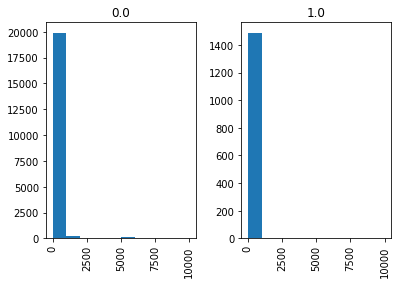

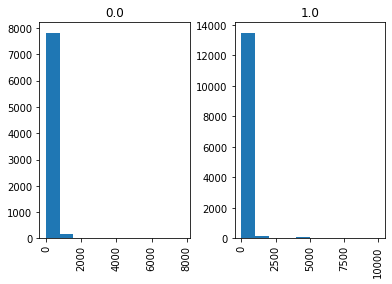

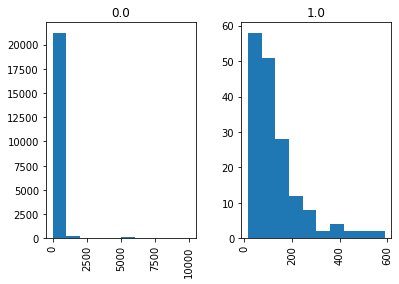

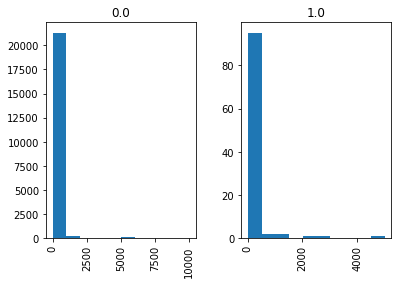

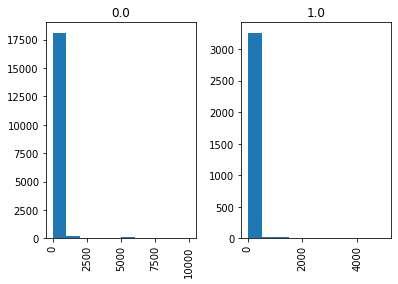

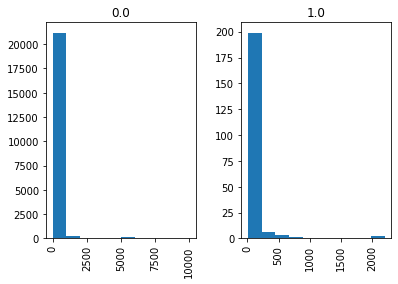

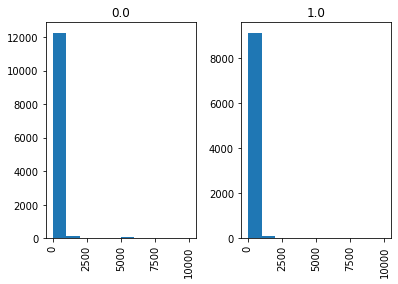

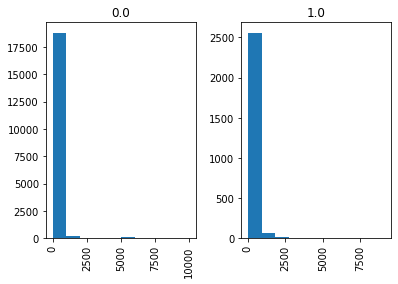

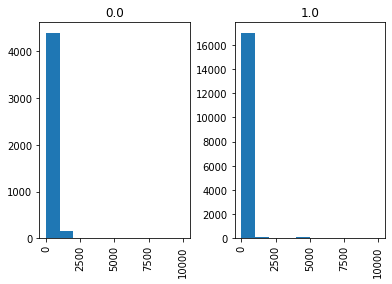

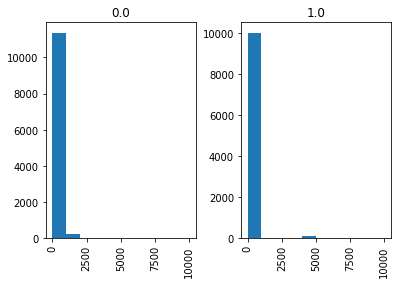

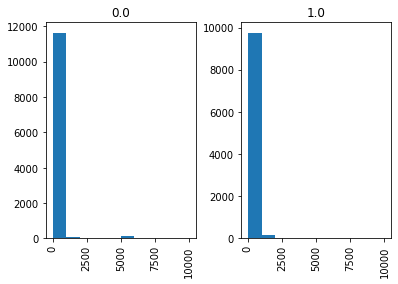

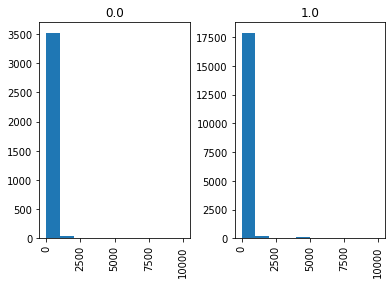

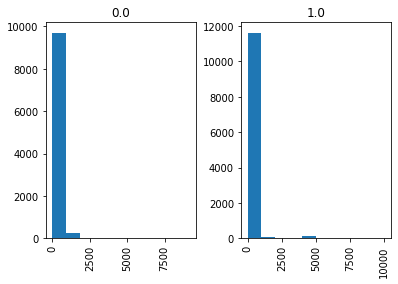

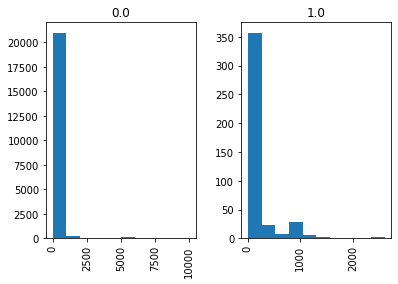

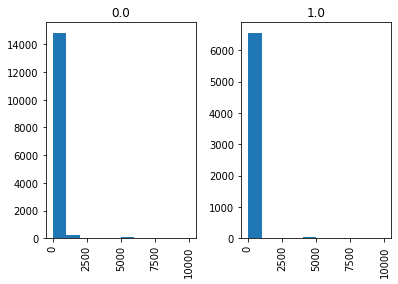

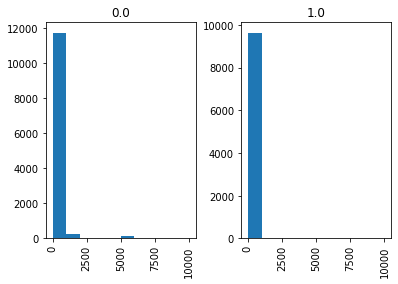

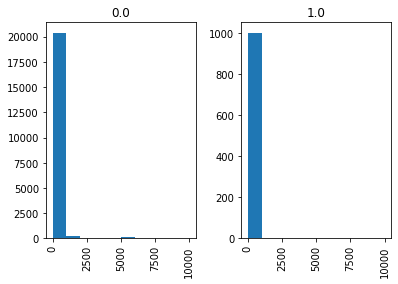

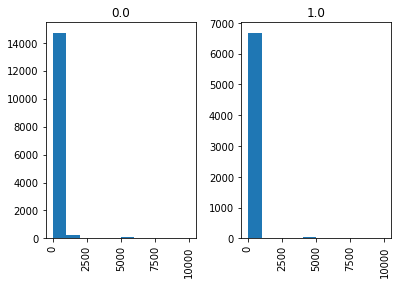

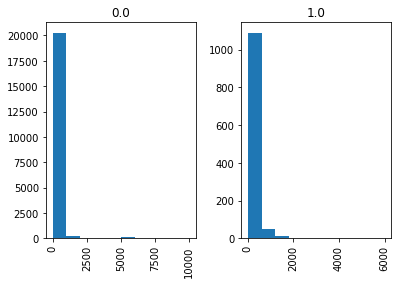

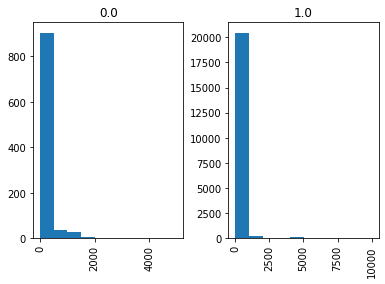

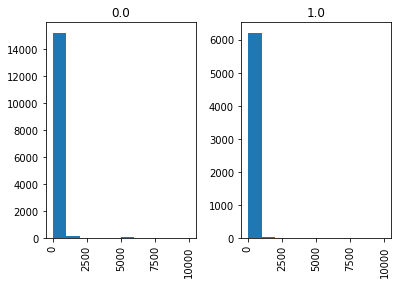

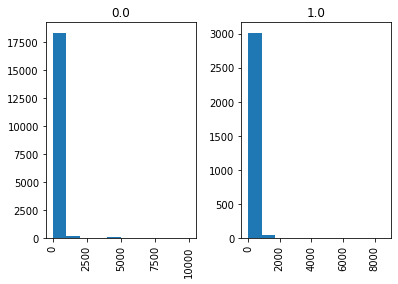

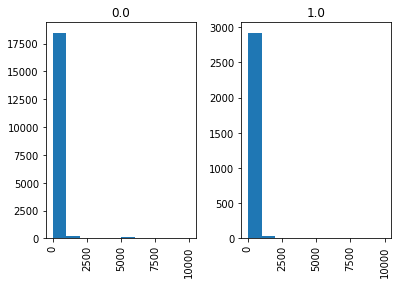

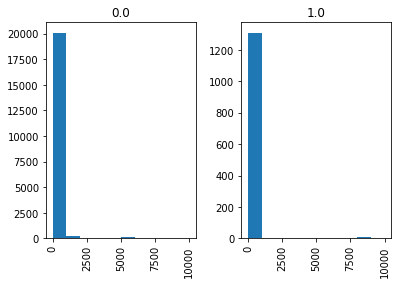

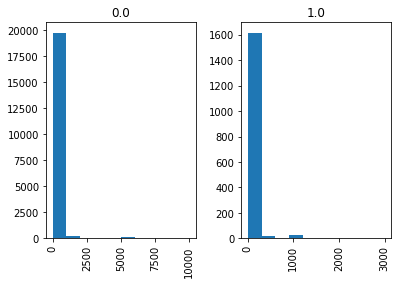

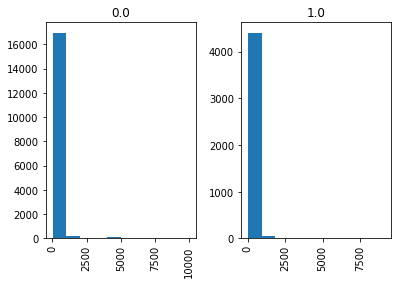

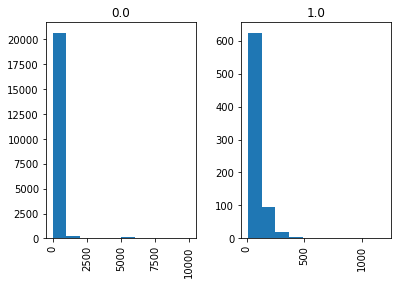

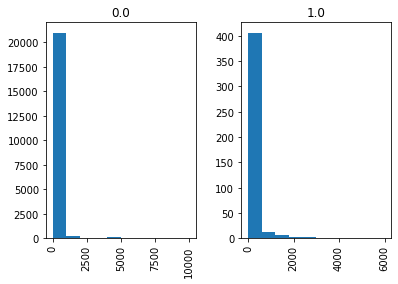

In [152]:
df.hist(column='price', by='check_in_24h')
df.hist(column='price', by='air_conditioning')
df.hist(column='price', by='high_end_electronics')
df.hist(column='price', by='bbq')
df.hist(column='price', by='balcony')
df.hist(column='price', by='nature_and_views')
df.hist(column='price', by='bed_linen')
df.hist(column='price', by='breakfast')
df.hist(column='price', by='tv')
df.hist(column='price', by='coffee_machine')
df.hist(column='price', by='cooking_basics')
df.hist(column='price', by='white_goods')
df.hist(column='price', by='elevator')
df.hist(column='price', by='gym')
df.hist(column='price', by='child_friendly')
df.hist(column='price', by='parking')
df.hist(column='price', by='outdoor_space')
df.hist(column='price', by='host_greeting')
df.hist(column='price', by='hot_tub_sauna_or_pool')
df.hist(column='price', by='internet')
df.hist(column='price', by='long_term_stays')
df.hist(column='price', by='pets_allowed')
df.hist(column='price', by='private_entrance')
df.hist(column='price', by='secure')
df.hist(column='price', by='self_check_in')
df.hist(column='price', by='smoking_allowed')
df.hist(column='price', by='accessible')
df.hist(column='price', by='event_suitable')

 From the histograms we can see all of the amenities offered have a right skewed distribution to price.

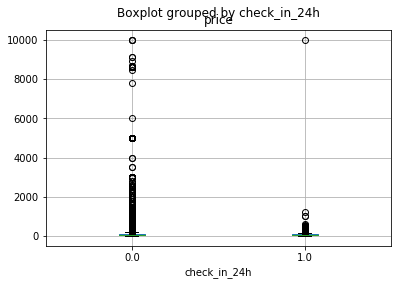

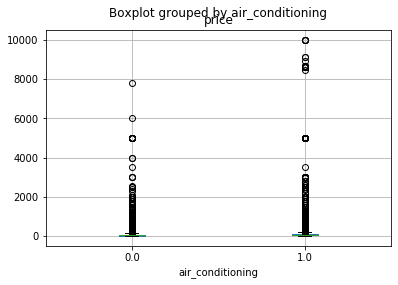

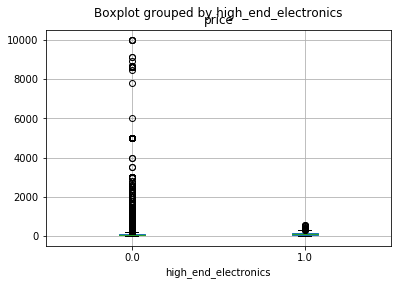

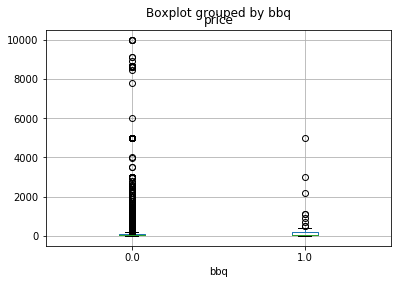

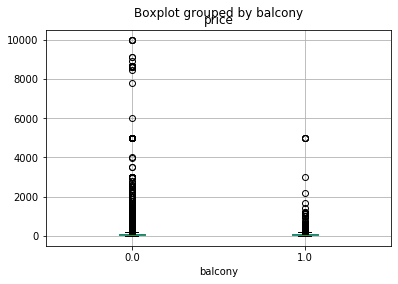

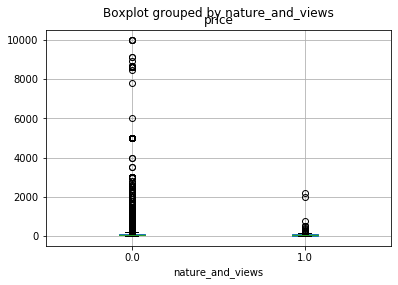

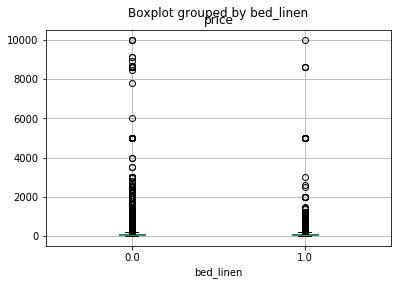

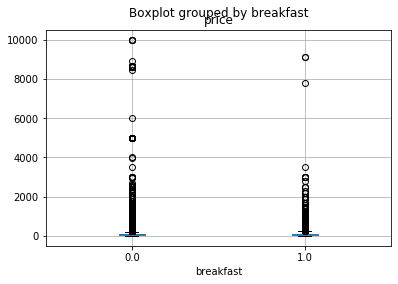

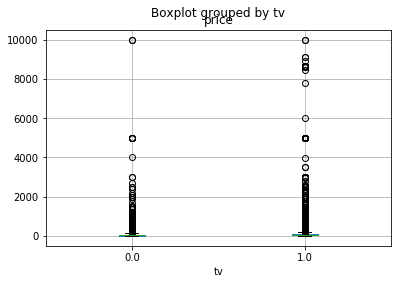

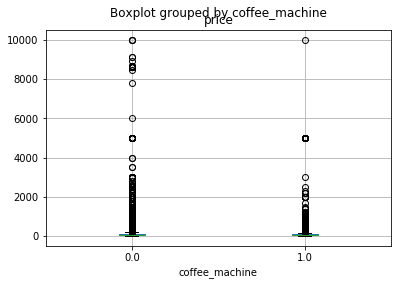

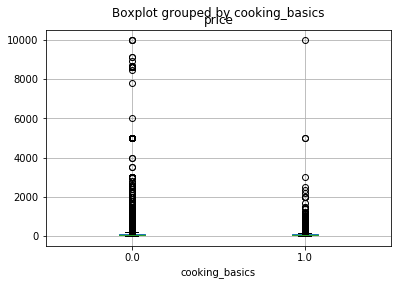

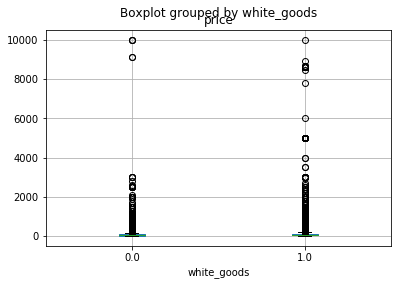

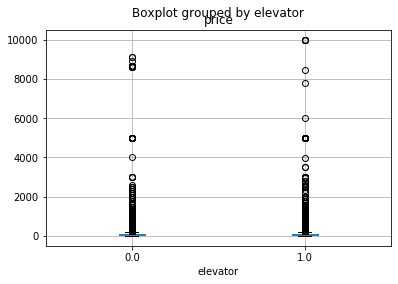

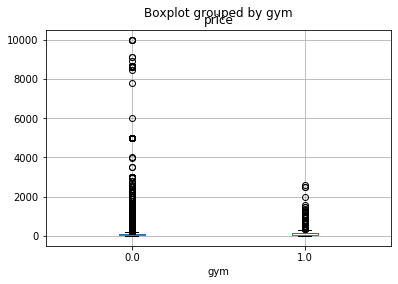

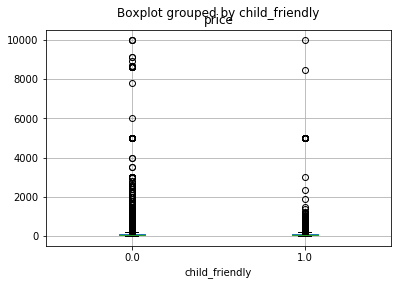

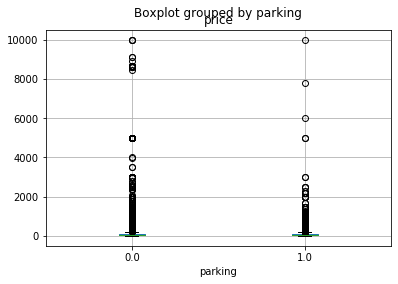

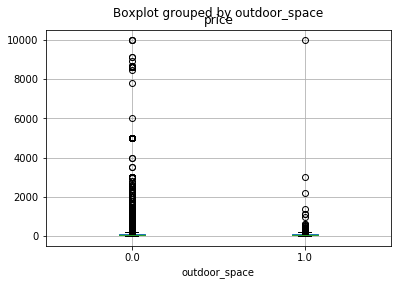

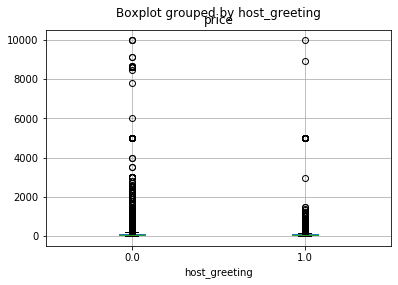

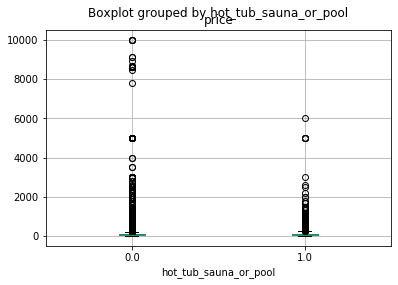

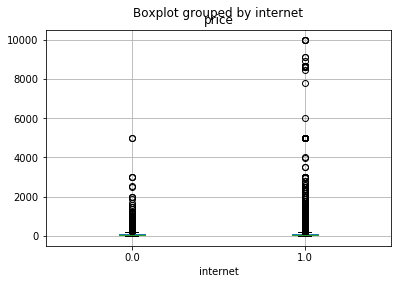

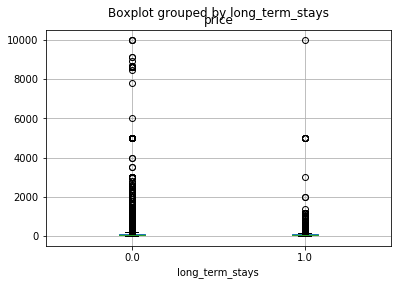

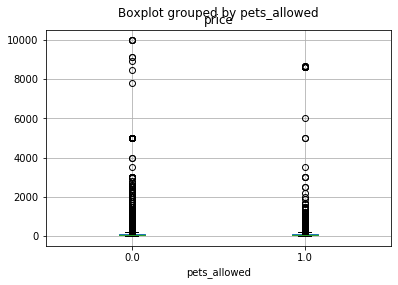

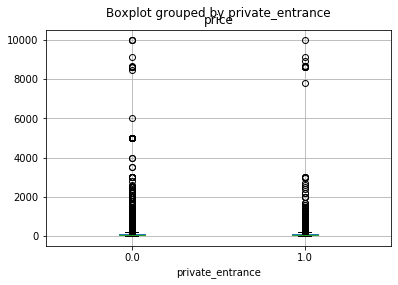

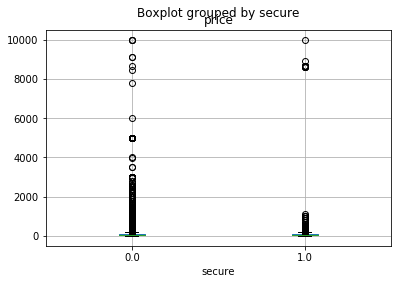

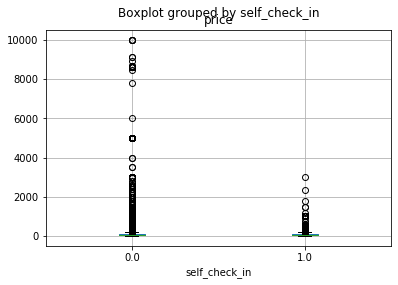

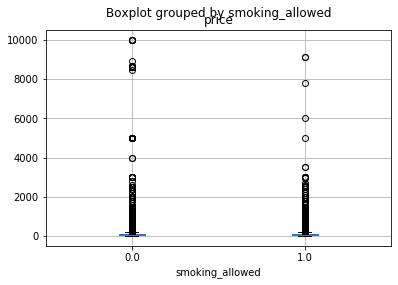

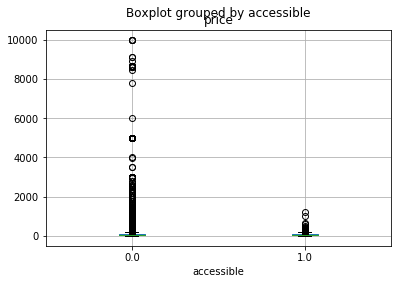

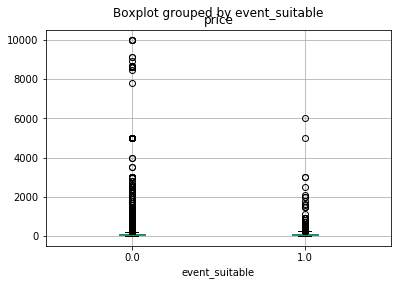

In [153]:
df.boxplot(column='price', by='check_in_24h')
df.boxplot(column='price', by='air_conditioning')
df.boxplot(column='price', by='high_end_electronics')
df.boxplot(column='price', by='bbq')
df.boxplot(column='price', by='balcony')
df.boxplot(column='price', by='nature_and_views')
df.boxplot(column='price', by='bed_linen')
df.boxplot(column='price', by='breakfast')
df.boxplot(column='price', by='tv')
df.boxplot(column='price', by='coffee_machine')
df.boxplot(column='price', by='cooking_basics')
df.boxplot(column='price', by='white_goods')
df.boxplot(column='price', by='elevator')
df.boxplot(column='price', by='gym')
df.boxplot(column='price', by='child_friendly')
df.boxplot(column='price', by='parking')
df.boxplot(column='price', by='outdoor_space')
df.boxplot(column='price', by='host_greeting')
df.boxplot(column='price', by='hot_tub_sauna_or_pool')
df.boxplot(column='price', by='internet')
df.boxplot(column='price', by='long_term_stays')
df.boxplot(column='price', by='pets_allowed')
df.boxplot(column='price', by='private_entrance')
df.boxplot(column='price', by='secure')
df.boxplot(column='price', by='self_check_in')
df.boxplot(column='price', by='smoking_allowed')
df.boxplot(column='price', by='accessible')
df.boxplot(column='price', by='event_suitable')

We can see from the boxplots that all amenities have upper bound outliers.

# Security_deposit

In [154]:
df.security_deposit.value_counts()

$0.00        5801
$100.00      2194
$200.00      1897
$150.00      1575
$300.00       778
             ... 
$3,670.00       1
$3,560.00       1
$890.00         1
$232.00         1
$875.00         1
Name: security_deposit, Length: 143, dtype: int64

In [155]:
df.security_deposit = df.security_deposit.str.replace('$','')
df.security_deposit = df.security_deposit.str.replace(',','')

In [156]:
df['security_deposit']=pd.to_numeric(df['security_deposit'])

Text(0.5, 1.0, 'security_deposit')

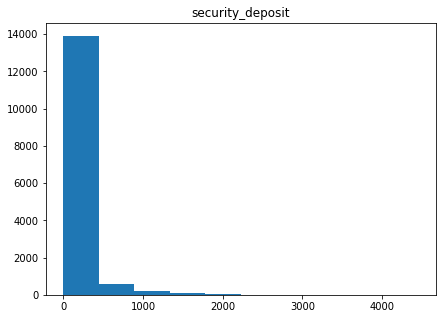

In [157]:
plt.figure(figsize=[7,5])
plt.hist(df['security_deposit'])
plt.title("security_deposit")

In [158]:
df.security_deposit.isna().sum()

6985

We have 6985 missing values.

We have decided to impute it with 0, as we interpret that if there is no value given, is because there is no deposit demanded.

In [159]:
df.security_deposit.fillna(0, inplace=True)

In [160]:
df.security_deposit.isna().sum()

0

We have decided that it would be more benefitial to know if there is a deposit imposed rather than the actual amount.

In [161]:
df.security_deposit[(df.security_deposit < 1)] = 0
df.security_deposit[(df.security_deposit >= 1)] = 1

In [162]:
df.security_deposit.value_counts()

0.0    12786
1.0     9047
Name: security_deposit, dtype: int64

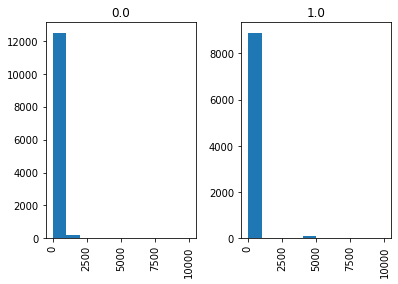

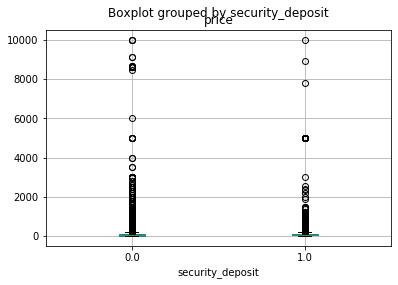

In [163]:
df.hist(column='price', by='security_deposit')
df.boxplot(column='price', by='security_deposit')

# Cleaning_fee

In [164]:
df.cleaning_fee.value_counts()

$0.00      2413
$30.00     1825
$20.00     1435
$40.00     1253
$10.00     1024
           ... 
$111.00       1
$171.00       1
$83.00        1
$271.00       1
$149.00       1
Name: cleaning_fee, Length: 143, dtype: int64

In [165]:
df.cleaning_fee = df.cleaning_fee.str.replace('$','')
df.cleaning_fee = df.cleaning_fee.str.replace(',','')

In [166]:
df['cleaning_fee']=pd.to_numeric(df['cleaning_fee'])

Text(0.5, 1.0, 'cleaning_fee')

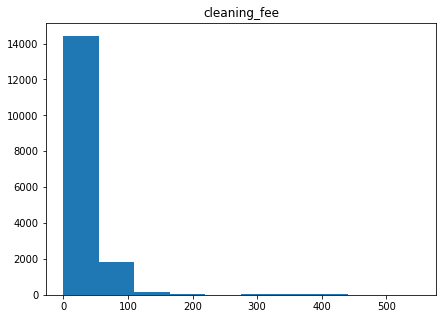

In [167]:
plt.figure(figsize=[7,5])
plt.hist(df['cleaning_fee'])
plt.title("cleaning_fee")

In [168]:
df.cleaning_fee.isna().sum()

5273

We have 5273 missing values.

We have decided to impute it with 0, as we interpret that if there is no value given, is because there is no fee demanded.

In [169]:
df.cleaning_fee.fillna(0, inplace=True)

In [170]:
df.cleaning_fee.isna().sum()

0

We have decided that it would be more benefitial to know if there is a fee imposed rather than the actual amount.

In [171]:
df.cleaning_fee[(df.cleaning_fee < 1)] = 0
df.cleaning_fee[(df.cleaning_fee >= 1)] = 1

In [172]:
df.cleaning_fee.value_counts()

1.0    14147
0.0     7686
Name: cleaning_fee, dtype: int64

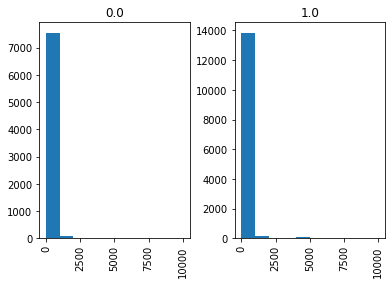

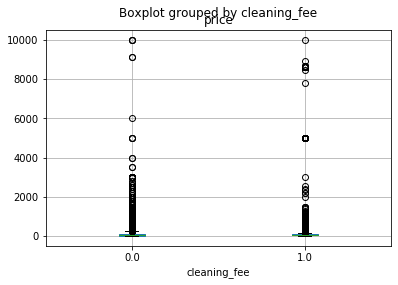

In [173]:
df.hist(column='price', by='cleaning_fee')
df.boxplot(column='price', by='cleaning_fee')

- 14,148 of the airbnbs have a cleaning fee
- 7,697 of the airbnbs don't have a cleaning fee

# Guests_included

In [174]:
df['guests_included'].describe()

count    21833.000000
mean         1.771905
std          1.400873
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: guests_included, dtype: float64

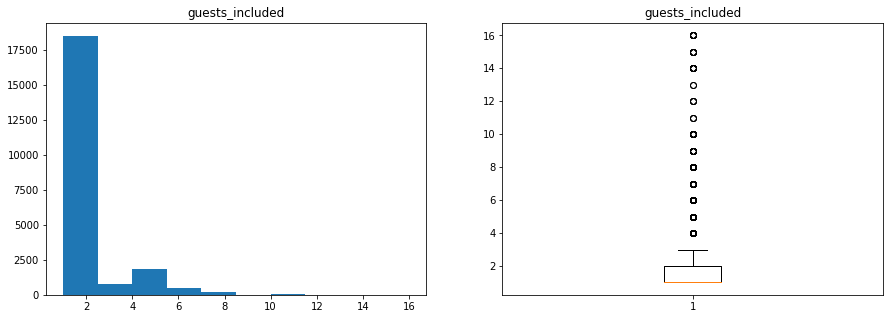

In [175]:
plt.figure(figsize=[15,5])
x = df['guests_included']

plt.subplot(121)
plt.hist(x)
plt.title("guests_included")

plt.subplot(122)
plt.boxplot(x)
plt.title("guests_included")
plt.show()

In [176]:
df['guests_included'].isna().sum()

0

Conclusions
- There is an average of 1.77 guests included per airbnb
- There is a minimum number of guests included per airbnb of 1
- There is a maximum number of guests included per airbnb of 16
- The distribution seems to be right skewed
- There are multiple outliers which will be dealt with later

# Extra_people

In [177]:
df.extra_people.value_counts()

$0.00      11686
$10.00      2395
$15.00      2368
$20.00      1340
$5.00        711
           ...  
$37.00         1
$89.00         1
$44.00         1
$59.00         1
$269.00        1
Name: extra_people, Length: 78, dtype: int64

In [178]:
df.extra_people = df.extra_people.str.replace('$','')
df.extra_people = df.extra_people.str.replace(',','')

In [179]:
df['extra_people']=pd.to_numeric(df['extra_people'])

In [180]:
df['extra_people'].isna().sum()

0

In [181]:
df['extra_people'].describe()

count    21833.000000
mean         8.455274
std         16.235782
min          0.000000
25%          0.000000
50%          0.000000
75%         15.000000
max        271.000000
Name: extra_people, dtype: float64

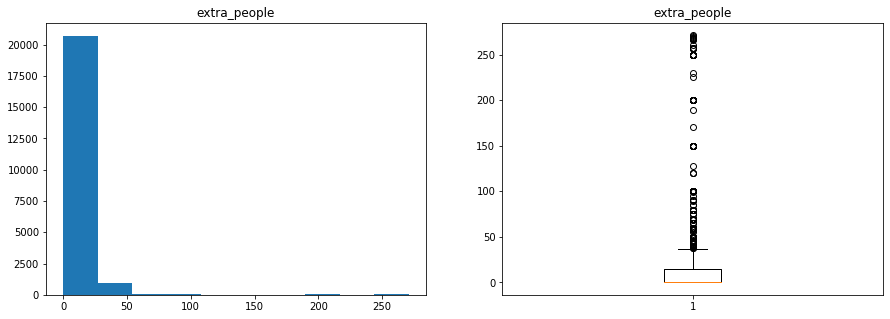

In [182]:
plt.figure(figsize=[15,5])
x = df['extra_people']

plt.subplot(121)
plt.hist(x)
plt.title("extra_people")

plt.subplot(122)
plt.boxplot(x)
plt.title("extra_people")
plt.show()

Conclusions
- Mean cost for extra person 8.45
- Minimum cost for extra person 0
- Maximum cost for extra person 271
- Distribution seems to be right skewed
- There exist multiple outliers, which will be dealt with later on

# Minimum Nights

In [183]:
df['minimum_nights'].describe()

count    21833.000000
mean         4.555718
std         23.684998
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       1125.000000
Name: minimum_nights, dtype: float64

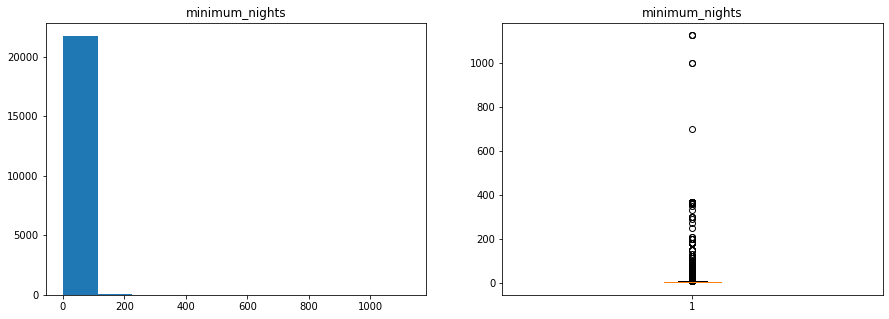

In [184]:
plt.figure(figsize=[15,5])
x = df['minimum_nights']

plt.subplot(121)
plt.hist(x)
plt.title("minimum_nights")

plt.subplot(122)
plt.boxplot(x)
plt.title("minimum_nights")
plt.show()

In [185]:
df['minimum_nights'].isna().sum()

0

Conclusions
- Mean minimum_nights is 4.55
- Minimum minimum_nights is 1
- Maximum minimum nights is 1125
- Distribution seems to be right skewed
- There exist multiple outliers, which will be dealt with later on

# Maximum_nights

In [186]:
df['maximum_nights'].describe()

count    2.183300e+04
mean     6.346259e+03
std      7.557134e+05
min      1.000000e+00
25%      4.000000e+01
50%      1.125000e+03
75%      1.125000e+03
max      1.111111e+08
Name: maximum_nights, dtype: float64

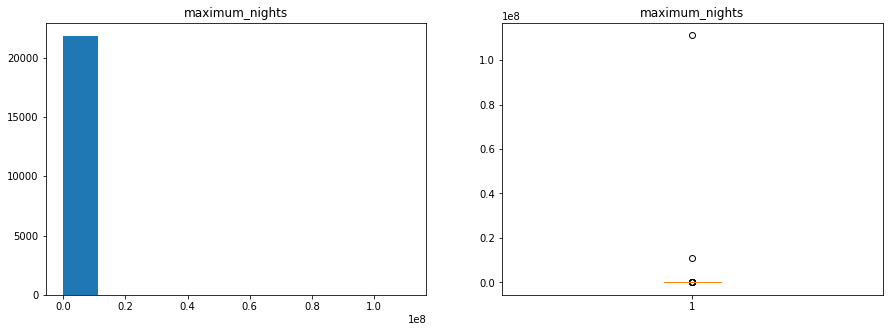

In [187]:
plt.figure(figsize=[15,5])
x = df['maximum_nights']

plt.subplot(121)
plt.hist(x)
plt.title("maximum_nights")

plt.subplot(122)
plt.boxplot(x)
plt.title("maximum_nights")
plt.show()

In [188]:
df['maximum_nights'].isna().sum()

0

Conclusions
- Mean maximum_nights is 6,343
- Minimum maximum_nights is 1
- Maximum maximum_nights nights is 111,111,111
- Distribution seems to be right skewed
- There exist multiple outliers, which will be dealt with later on

# Availability_365

In [189]:
df['availability_365'].describe()

count    21833.000000
mean       162.953602
std        132.791136
min          0.000000
25%         33.000000
50%        145.000000
75%        297.000000
max        365.000000
Name: availability_365, dtype: float64

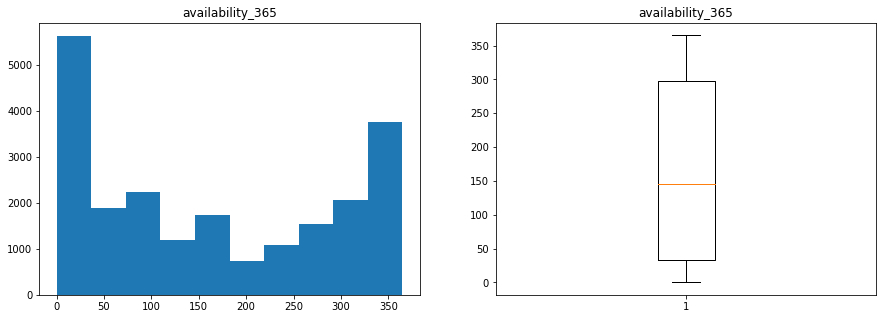

In [190]:
plt.figure(figsize=[15,5])
x = df['availability_365']

plt.subplot(121)
plt.hist(x)
plt.title("availability_365")

plt.subplot(122)
plt.boxplot(x)
plt.title("availability_365")
plt.show()

In [191]:
df['availability_365'].isna().sum()

0

Conclusions
- Mean availability_365 is 162.96
- Minimum availability_365 is 0
- Maximum availability_365 nights is 365
- Distribution seems: there doesn't seem to be any kind of distribution
- No outliers

We think that `availability_365` will mean more to the price than `availability_30`, `availability_60` or `availability_90`. 

Thus, we decide to drop these last 3.

In [192]:
df.drop(['availability_30','availability_60','availability_90'], axis = 1, inplace = True)

# Number_of_reviews_ltm

In [193]:
df['number_of_reviews_ltm'].describe()

count    21833.000000
mean        14.728851
std         21.973827
min          0.000000
25%          0.000000
50%          4.000000
75%         21.000000
max        326.000000
Name: number_of_reviews_ltm, dtype: float64

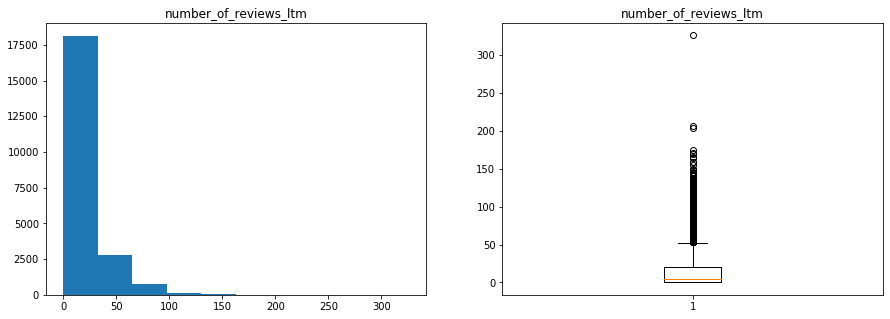

In [194]:
plt.figure(figsize=[15,5])
x = df['number_of_reviews_ltm']

plt.subplot(121)
plt.hist(x)
plt.title("number_of_reviews_ltm")

plt.subplot(122)
plt.boxplot(x)
plt.title("number_of_reviews_ltm")
plt.show()

In [195]:
df['number_of_reviews_ltm'].isna().sum()

0

Conclusions
- ltm: last twelve months
- Mean number_of_reviews_ltm is 14.72
- Minimum number_of_reviews_ltm is 0
- Maximum number_of_reviews_ltm nights is 326
- Distribution: seems to be right skewed
- There seems to be multiple outlieers, which will be looked at later on

# Review_scores_accuracy

In [196]:
df['review_scores_accuracy'].describe()

count    17098.000000
mean         9.510528
std          0.905573
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_accuracy, dtype: float64

Text(0.5, 1.0, 'review_scores_accuracy')

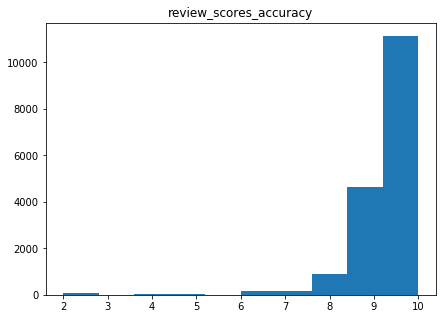

In [197]:
plt.figure(figsize=[7,5])
plt.hist(df['review_scores_accuracy'])
plt.title("review_scores_accuracy")

In [198]:
df.review_scores_accuracy.isna().sum()

4735

We have 4735 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [199]:
df.review_scores_accuracy.fillna(df.review_scores_accuracy.mode()[0], inplace=True)

In [200]:
df.review_scores_accuracy.isna().sum()

0

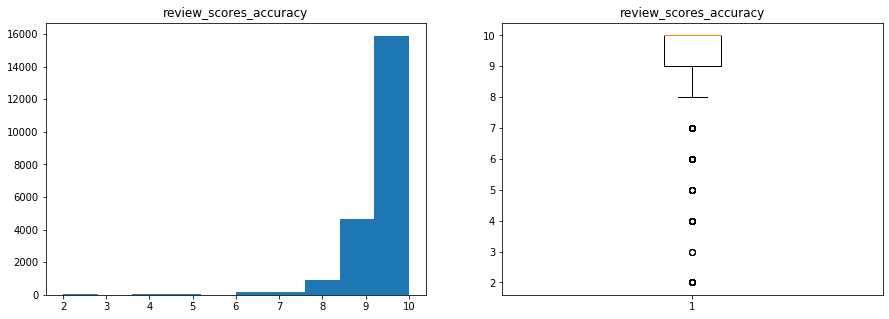

In [201]:
plt.figure(figsize=[15,5])
x = df['review_scores_accuracy']

plt.subplot(121)
plt.hist(x)
plt.title("review_scores_accuracy")

plt.subplot(122)
plt.boxplot(x)
plt.title("review_scores_accuracy")
plt.show()

Conclusions
- Mean review_scores_accuracy is 9.62
- Minimum review_scores_accuracy is 2
- Maximum review_scores_accuracy nights is 10
- Distribution: seems to be left skewed
- There seems to be multiple outlieers, which will be looked at later on

# Review_scores_cleanliness

In [202]:
df['review_scores_cleanliness'].describe()

count    17101.000000
mean         9.365066
std          0.982832
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_cleanliness, dtype: float64

Text(0.5, 1.0, 'review_scores_cleanliness')

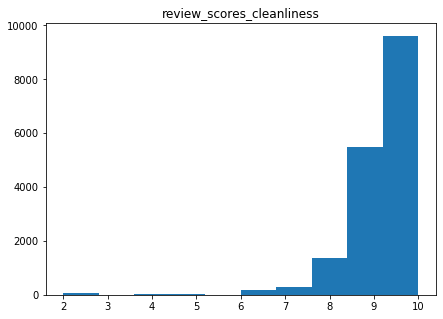

In [203]:
plt.figure(figsize=[7,5])
plt.hist(df['review_scores_cleanliness'])
plt.title("review_scores_cleanliness")

In [204]:
df.review_scores_cleanliness.isna().sum()

4732

We have 4732 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [205]:
df.review_scores_cleanliness.fillna(df.review_scores_cleanliness.mode()[0], inplace=True)

In [206]:
df.review_scores_cleanliness.isna().sum()

0

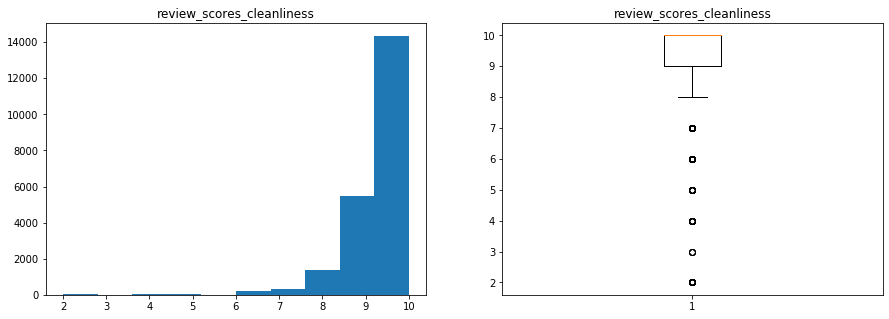

In [207]:
plt.figure(figsize=[15,5])
x = df['review_scores_cleanliness']

plt.subplot(121)
plt.hist(x)
plt.title("review_scores_cleanliness")

plt.subplot(122)
plt.boxplot(x)
plt.title("review_scores_cleanliness")
plt.show()

Conclusions
- Mean review_scores_cleanliness is 9.50
- Minimum review_scores_cleanliness is 2
- Maximum review_scores_cleanliness nights is 10
- Distribution: seems to be left skewed
- There seems to be multiple outlieers, which will be looked at later on

# Review_scores_checkin

In [208]:
df['review_scores_checkin'].describe()

count    17100.000000
mean         9.615614
std          0.842689
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_checkin, dtype: float64

Text(0.5, 1.0, 'review_scores_checkin')

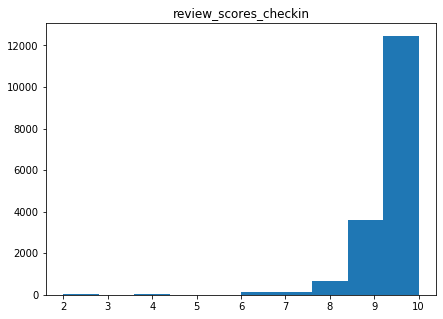

In [209]:
plt.figure(figsize=[7,5])
plt.hist(df['review_scores_checkin'])
plt.title("review_scores_checkin")

In [210]:
df.review_scores_checkin.isna().sum()

4733

We have 4733 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [211]:
df.review_scores_checkin.fillna(df.review_scores_checkin.mode()[0], inplace=True)

In [212]:
df.review_scores_checkin.isna().sum()

0

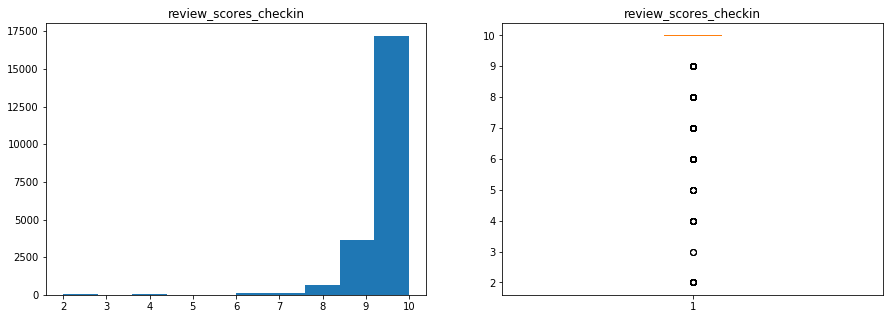

In [213]:
plt.figure(figsize=[15,5])
x = df['review_scores_checkin']

plt.subplot(121)
plt.hist(x)
plt.title("review_scores_checkin")

plt.subplot(122)
plt.boxplot(x)
plt.title("review_scores_checkin")
plt.show()

Conclusions
- Mean review_scores_checkin is 9.70
- Minimum review_scores_checkin is 2
- Maximum review_scores_checkin nights is 10
- Distribution: seems to be left skewed
- There seems to be multiple outlieers, which will be looked at later on

# Review_scores_communication

In [214]:
df['review_scores_communication'].describe()

count    17100.000000
mean         9.638713
std          0.830791
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_communication, dtype: float64

Text(0.5, 1.0, 'review_scores_communication')

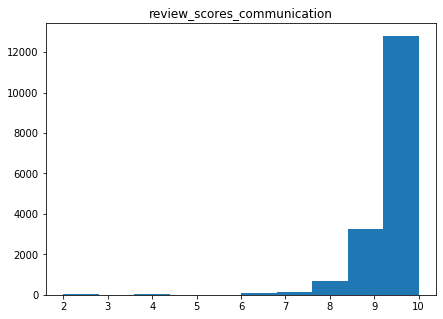

In [215]:
plt.figure(figsize=[7,5])
plt.hist(df['review_scores_communication'])
plt.title("review_scores_communication")

In [216]:
df.review_scores_communication.isna().sum()

4733

We have 4733 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [217]:
df.review_scores_communication.fillna(df.review_scores_communication.mode()[0], inplace=True)

In [218]:
df.review_scores_communication.isna().sum()

0

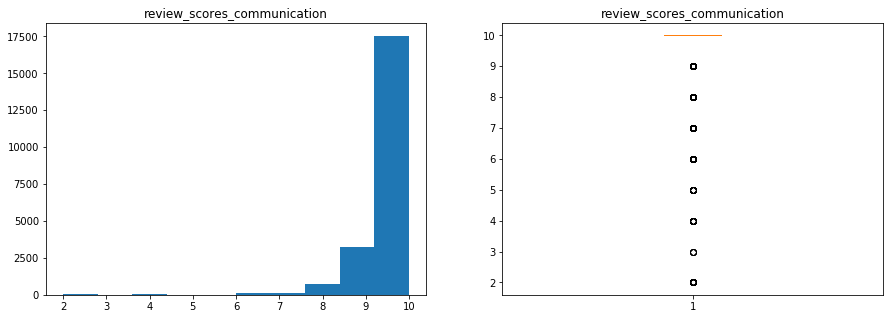

In [219]:
plt.figure(figsize=[15,5])
x = df['review_scores_communication']

plt.subplot(121)
plt.hist(x)
plt.title("review_scores_communication")

plt.subplot(122)
plt.boxplot(x)
plt.title("review_scores_communication")
plt.show()

Conclusions
- Mean review_scores_communication is 9.72
- Minimum review_scores_communication is 2
- Maximum review_scores_communication nights is 10
- Distribution: seems to be left skewed
- There seems to be multiple outlieers, which will be looked at later on

# Review_scores_location

In [220]:
df['review_scores_location'].describe()

count    17097.000000
mean         9.658478
std          0.720824
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_location, dtype: float64

Text(0.5, 1.0, 'review_scores_location')

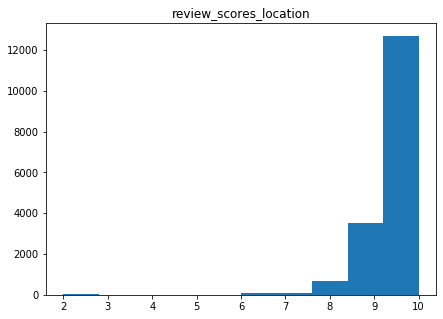

In [221]:
plt.figure(figsize=[7,5])
plt.hist(df['review_scores_location'])
plt.title("review_scores_location")

In [222]:
df.review_scores_location.isna().sum()

4736

We have 4736 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [223]:
df.review_scores_location.fillna(df.review_scores_location.mode()[0], inplace=True)

In [224]:
df.review_scores_location.isna().sum()

0

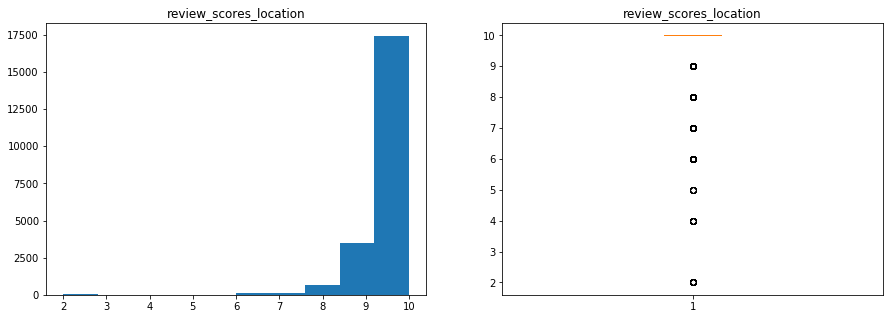

In [225]:
plt.figure(figsize=[15,5])
x = df['review_scores_location']

plt.subplot(121)
plt.hist(x)
plt.title("review_scores_location")

plt.subplot(122)
plt.boxplot(x)
plt.title("review_scores_location")
plt.show()

Conclusions
- Mean review_scores_location is 9.73
- Minimum review_scores_location is 2
- Maximum review_scores_location nights is 10
- Distribution: seems to be left skewed
- There seems to be multiple outlieers, which will be looked at later on

# Review_scores_value

In [226]:
df['review_scores_value'].describe()

count    17096.000000
mean         9.164541
std          0.994931
min          2.000000
25%          9.000000
50%          9.000000
75%         10.000000
max         10.000000
Name: review_scores_value, dtype: float64

Text(0.5, 1.0, 'review_scores_value')

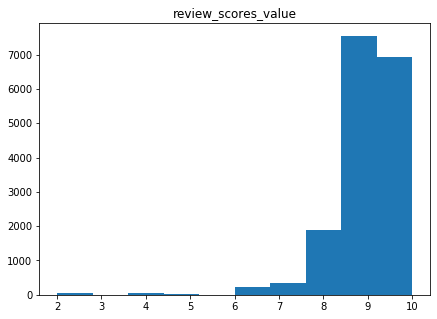

In [227]:
plt.figure(figsize=[7,5])
plt.hist(df['review_scores_value'])
plt.title("review_scores_value")

In [228]:
df.review_scores_value.isna().sum()

4737

We have 4737 missing values.

We decided to fill them with the mode, because the distribution is skewed.

In [229]:
df.review_scores_value.fillna(df.review_scores_value.mode()[0], inplace=True)

In [230]:
df.review_scores_value.isna().sum()

0

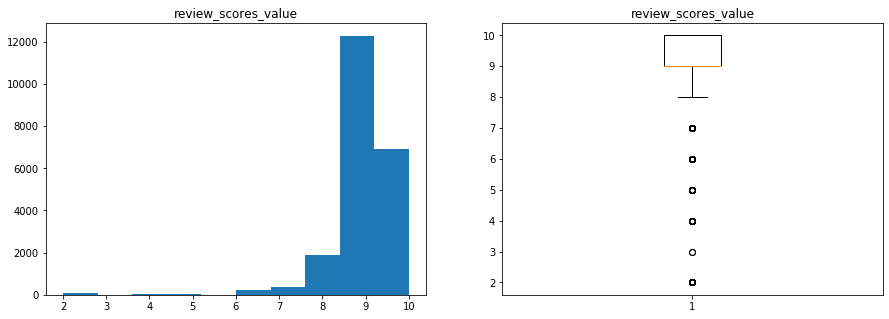

In [231]:
plt.figure(figsize=[15,5])
x = df['review_scores_value']

plt.subplot(121)
plt.hist(x)
plt.title("review_scores_value")

plt.subplot(122)
plt.boxplot(x)
plt.title("review_scores_value")
plt.show()

Conclusions
- Mean review_scores_value is 9.13
- Minimum review_scores_value is 2
- Maximum review_scores_value nights is 10
- Distribution: seems to be left skewed
- There seems to be multiple outlieers, which will be looked at later on

# Instant_bookable

In [232]:
df.instant_bookable.value_counts()

t    13419
f     8414
Name: instant_bookable, dtype: int64

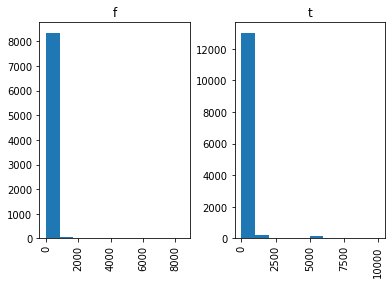

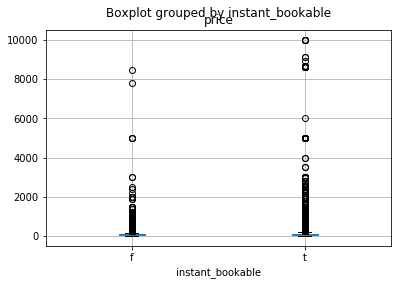

In [233]:
df.hist(column='price', by='instant_bookable')
df.boxplot(column='price', by='instant_bookable')

In [234]:
df.instant_bookable.isna().sum()

0

In [235]:
#replacing trues for 1 and false with 0
df.instant_bookable = df.instant_bookable.replace('t',1)
df.instant_bookable = df.instant_bookable.replace('f',0)

In [236]:
df.instant_bookable.value_counts()

1    13419
0     8414
Name: instant_bookable, dtype: int64

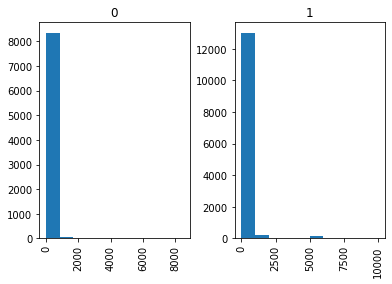

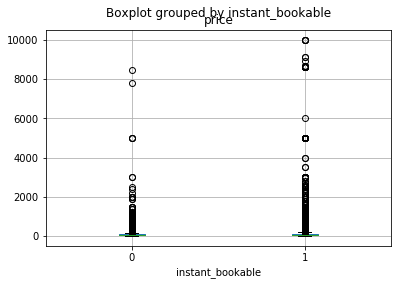

In [237]:
df.hist(column='price', by='instant_bookable')
df.boxplot(column='price', by='instant_bookable')

Conclusions
- There are 13,426 airbnbs which have instant booking
- There are 8,419 airbnbs which don't have instant booking

# Require_guest_profile_picture

In [238]:
df.require_guest_profile_picture.value_counts()

f    21630
t      203
Name: require_guest_profile_picture, dtype: int64

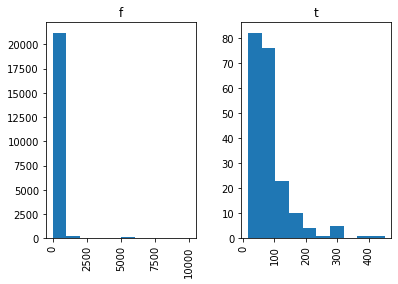

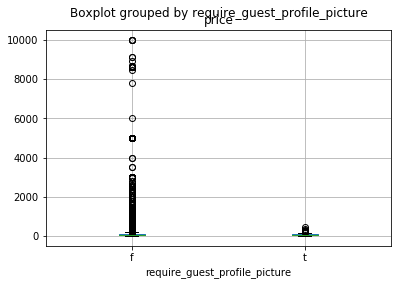

In [239]:
df.hist(column='price', by='require_guest_profile_picture')
df.boxplot(column='price', by='require_guest_profile_picture')

In [240]:
df.require_guest_profile_picture.isna().sum()

0

In [241]:
#replacing trues for 1 and false with 0
df.require_guest_profile_picture = df.require_guest_profile_picture.replace('t',1)
df.require_guest_profile_picture = df.require_guest_profile_picture.replace('f',0)

In [242]:
df.require_guest_profile_picture.value_counts()

0    21630
1      203
Name: require_guest_profile_picture, dtype: int64

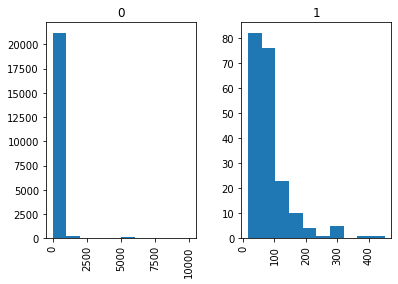

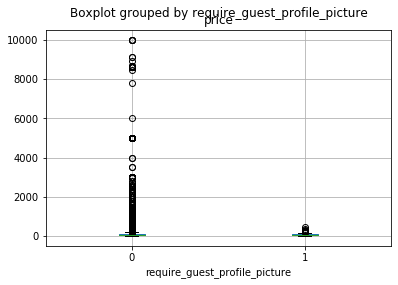

In [243]:
df.hist(column='price', by='require_guest_profile_picture')
df.boxplot(column='price', by='require_guest_profile_picture')

Conclusions
- 21,642 airbnbs require their guests to have a profile picture
- 203 airbnbs don't require their guests to have a profile picture

# Require_guest_phone_verification

In [244]:
df.require_guest_phone_verification.value_counts()

f    21519
t      314
Name: require_guest_phone_verification, dtype: int64

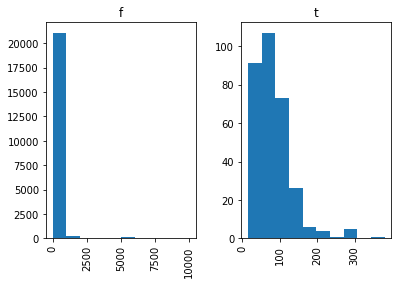

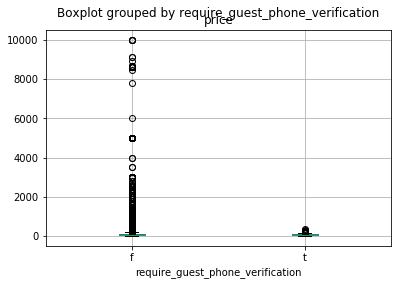

In [245]:
df.hist(column='price', by='require_guest_phone_verification')
df.boxplot(column='price', by='require_guest_phone_verification')

In [246]:
df.require_guest_phone_verification.isna().sum()

0

In [247]:
#replacing trues for 1 and false with 0
df.require_guest_phone_verification = df.require_guest_phone_verification.replace('t',1)
df.require_guest_phone_verification = df.require_guest_phone_verification.replace('f',0)

In [248]:
df.require_guest_phone_verification.value_counts()

0    21519
1      314
Name: require_guest_phone_verification, dtype: int64

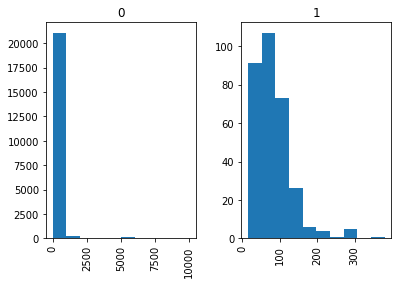

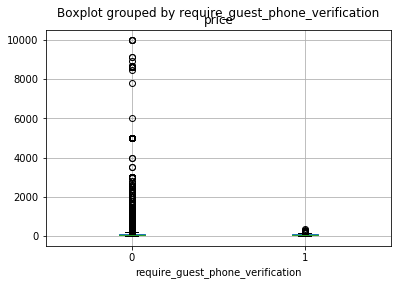

In [249]:
df.hist(column='price', by='require_guest_phone_verification')
df.boxplot(column='price', by='require_guest_phone_verification')

Conclusions
- 21,531 airbnbs require their guests to have phone verification
- 314 airbnbs require their guests to have phone verification

# Numeric Multivariate

In [250]:
numer=['price', 'review_scores_value','review_scores_location','review_scores_communication','review_scores_checkin','review_scores_cleanliness',
       'review_scores_accuracy','number_of_reviews_ltm','availability_365','maximum_nights','minimum_nights','extra_people','guests_included',
       'cleaning_fee','security_deposit','beds','bedrooms','bathrooms','accommodates','host_listings_count','host_acceptance_rate',
       'host_response_rate']

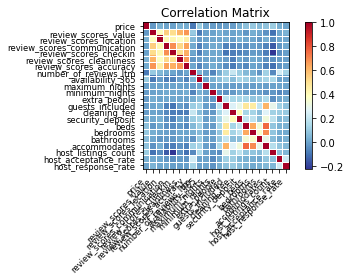

In [251]:
import statsmodels.api as sm
from scipy.special import factorial
corr = df[numer].corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

## NLP Variables

In [252]:
nlp_variables = ['name','summary','space','description','transit','access','interaction','host_about','neighborhood_overview','notes','house_rules']

In [253]:
df[nlp_variables].head()

,name,summary,space,description,transit,access,interaction,host_about,neighborhood_overview,notes,house_rules
0,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,BETTER THAN A HOTEL.Upscale neighboorhood (Met...,Excellent connection with the AIRPORT and EXHI...,Excelent public transport and easy Access to m...,"Full use of living room, kitchen (with dishwas...","English, spanish, german, russian, some french...","Gay couple, heterofriendly, enjoy having guest...",Nice and definitely non touristic neighborhoo...,If you are a group/family 3 or 4 people we off...,NaN
1,Bright and airy room,We have a quiet and sunny room with a good vie...,I am living in a nice flat near the centre of ...,We have a quiet and sunny room with a good vie...,The flat is near the centre of Madrid (15 minu...,There is fibre optic internet connection for y...,If I am at home and see each other around here...,EN-ES-FR\r\nEN\r\nHi everybody: I'm Abdel. I'm...,We live in a leafy neighbourhood with plenty o...,We are a 15 min bus ride away from the Casa de...,Gracias por no fumar en la casa. Es muy import...
2,Apartmento Arganzuela- Madrid Rio,"Apartamento de tres dormitorios dobles, gran s...","Apartamento de lujo, tres dormitorios dobles i...","Apartamento de tres dormitorios dobles, gran s...",NaN,"Piscina de verano, zonas comunes en el interio...",NaN,"Hi,\r\n\r\nWelcome to my apartments in the dow...","Barrio Arganzuela, junto a Madrid Rio, zonas c...",NaN,"Preparacion apartamento , entrega llaves 20 € ..."
3,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...",LOCATION. Brand new flats near the Atlantic H...,"Studio located 50 meters from Gran Via, next t...",To go from the airport you have several differ...,Apartment with elevator has a storage room for...,I put at the disposal of my guests to facilita...,"I love treating my clients, how I would like t...","The area is next to the Gran Via, so people li...",Just enjoy your trip.,Durante tu estancia es tu casa. Sientete en el...
4,"Select the Madrid more ""cool"".",Apartamento céntrico junto a Gran Vía (VT-296)...,"Select the Madrid more ""cool"" : 70 m, 2 bedroo...","Select the Madrid more ""cool"" : 70 m, 2 bedroo...",La situación del apartamento hace accesibles a...,La disponibilidad de acceso al apartamento es ...,El precio marcado es por el alojamiento comple...,Mi mayor pasión es viajar y conocer culturas d...,"Cosmopolita, lleno de locales de moda, restaur...",Al estar en el distrito Centro (Barrio de Just...,"El apartamento admite bebés, aunque no tiene c..."


We can see that these variables contain text. Therefore, we will consider some NLP techniques in next steps of the process.

In [254]:
df[nlp_variables].isna().sum()

name                         3
summary                   1358
space                     6288
description                827
transit                   8195
access                   11177
interaction               9062
host_about               10134
neighborhood_overview     7475
notes                    12949
house_rules               8940
dtype: int64

In [255]:
df.drop(['name','summary','space','description', 'neighborhood_overview','notes','transit','access','interaction','house_rules','host_about','is_location_exact'], axis=1, inplace=True)

# Last Droppings

## Dropping Variables 

### URLs

We will not need the URLs provided for our `Listings_Cleaned.csv` dataset, as we have only used them to impute the missing values.

In [256]:
urls_to_drop = ['listing_url','host_thumbnail_url','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_picture_url']

In [257]:
df = df.drop(urls_to_drop,axis=1)

### IDs

We will not need the IDs provided for our `Listings_Cleaned.csv` dataset, as we have only used them to impute the missing values, and wee are not going to perform any further mergings.

In [258]:
ids_to_drop = ['scrape_id','id','host_id','host_name','license']

In [259]:
df = df.drop(ids_to_drop,axis=1)

### Calculated Variables

We cannot consider these calculated variables in our `Listings_Cleaned.csv`, as we do not how this calculations have been performed, and tthus, cannot interpret their meanings.

In [260]:
calcvbles_to_drop = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','review_scores_rating',\
                     'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',\
                     'calculated_host_listings_count_shared_rooms','host_total_listings_count','minimum_nights_avg_ntm','maximum_nights_avg_ntm']

In [261]:
df = df.drop(calcvbles_to_drop,axis=1)

### Date Variables

We have performed already the transformations over date variables that where of interest for the study.

In [262]:
datevbles_to_drop = ['last_scraped','calendar_updated','has_availability','calendar_last_scraped','first_review','last_review']

In [263]:
df = df.drop(datevbles_to_drop,axis=1)

### Others

In [264]:
others_to_drop = ['experiences_offered','requires_license','jurisdiction_names','is_business_travel_ready']

In [265]:
for vble in others_to_drop:
  print('\n-----{0}-----'.format(vble))
  print(df[vble].value_counts())


-----experiences_offered-----
none    21833
Name: experiences_offered, dtype: int64

-----requires_license-----
t    21833
Name: requires_license, dtype: int64

-----jurisdiction_names-----
Series([], Name: jurisdiction_names, dtype: int64)

-----is_business_travel_ready-----
f    21833
Name: is_business_travel_ready, dtype: int64


We can see that:

- `'experiences_offered'`: only possible value is 'none'
- `'requires_license'` : only possible value is 't'
- `'jurisdiction_names'`: the variable is empty
- `'is_business_travel_ready'` : only possible value is 'f'

For the reasons showed above, we will drop these variables.

In [266]:
df = df.drop(others_to_drop,axis=1)

#### Dropping more variables

##### Square feet

In [267]:
df.square_feet.value_counts()

0.0       128
807.0       9
538.0       9
646.0       7
108.0       7
         ... 
50.0        1
9.0         1
1453.0      1
1711.0      1
398.0       1
Name: square_feet, Length: 75, dtype: int64

In [268]:
df.square_feet.isna().sum()

21542

We dropped square feet because it had 98.66% of missing values

In [269]:
df = df.drop('square_feet',axis=1)

#### Weekly price

In [270]:
df.weekly_price.value_counts()

$300.00      72
$400.00      71
$350.00      67
$200.00      62
$450.00      61
             ..
$1,843.00     1
$865.00       1
$1,250.00     1
$142.00       1
$485.00       1
Name: weekly_price, Length: 291, dtype: int64

In [271]:
df.weekly_price.isna().sum()

20238

Remove because it has 92.69% missing values and it's not our dependent variable

In [272]:
df = df.drop('weekly_price',axis=1)

##### Monthly price

In [273]:
df.monthly_price.value_counts()

$1,500.00    70
$1,200.00    52
$1,300.00    51
$1,000.00    48
$450.00      43
             ..
$601.00       1
$1,910.00     1
$987.00       1
$6,990.00     1
$399.00       1
Name: monthly_price, Length: 332, dtype: int64

In [274]:
df.monthly_price.isna().sum()

20338

We removed this variable because it has 93.16% of missing values and once again is not our target variable.

In [275]:
df = df.drop('monthly_price',axis=1)

##### Reviews per Month

In [276]:
df.reviews_per_month.value_counts()

1.00     378
0.11     245
2.00     152
0.07     147
0.03     145
        ... 
12.06      1
7.57       1
9.44       1
10.21      1
6.58       1
Name: reviews_per_month, Length: 917, dtype: int64

In [277]:
df.reviews_per_month.isna().sum()

4469

We removed reviews per month because it has 20.49% missing values. We also removed it because number of reviews for the last twelve months is more representative.

In [278]:
df = df.drop('reviews_per_month',axis=1)

##### Number of reviews

In [279]:
df.number_of_reviews.value_counts()

0      4469
1      1773
2      1133
3       857
4       656
       ... 
450       1
546       1
486       1
654       1
543       1
Name: number_of_reviews, Length: 448, dtype: int64

In [280]:
df.number_of_reviews.isna().sum()

0

Remove because we don't know how long each listing has been posted  so it wouldn’t be the same time for all

In [281]:
df = df.drop('number_of_reviews',axis=1)

##### Property type

In [282]:
df.property_type.value_counts()

Apartment                 17770
House                      1223
Condominium                 835
Loft                        738
Serviced apartment          301
Hostel                      264
Bed and breakfast           137
Guest suite                  77
Guesthouse                   70
Townhouse                    70
Other                        65
Boutique hotel               64
Chalet                       57
Hotel                        49
Tiny house                   28
Casa particular (Cuba)       23
Camper/RV                    18
Villa                        11
Aparthotel                    7
Dome house                    7
Hut                           3
Earth house                   3
Barn                          2
Bungalow                      2
Yurt                          1
Castle                        1
Nature lodge                  1
Cottage                       1
Igloo                         1
Campsite                      1
Pension (South Korea)         1
Farm sta

In [283]:
df.property_type.isna().sum()

0

We removed this variable because as it can be seen in the value counts above the options were all strange. Most likely, there isn't any airbnb that's an igloo in Madrid.

In [284]:
df = df.drop('property_type',axis=1)

# Final Check for NA's

In [285]:
df.columns[df.isna().sum() != 0]

Index([], dtype='object')

# Final Dataset

In [286]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews_ltm,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,host_for,email,facebook,google,government,external_verifications,manual,phone,reviews,selfie,sent_id,area_name,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
0,within a few hours,4.0,3.0,1,1.0,1,0,Private room,2,1.0,1.0,0.0,Real Bed,70.0,0.0,1.0,2,15.0,1,365,77,14,10.0,10.0,10.0,10.0,10.0,10.0,0,flexible,0,0,4010,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,Chamartin,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,within an hour,4.0,4.0,0,2.0,1,1,Private room,1,1.0,1.0,1.0,Real Bed,17.0,0.0,0.0,1,8.0,4,40,200,0,9.0,9.0,10.0,10.0,8.0,9.0,0,strict_14_with_grace_period,0,0,3699,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,Latina,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,within an hour,4.0,3.0,0,9.0,1,0,Entire home/apt,6,2.0,3.0,5.0,Real Bed,50.0,1.0,1.0,1,10.0,15,730,249,0,10.0,10.0,10.0,10.0,10.0,9.0,0,moderate,0,0,3703,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,Usera,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,within a few hours,4.0,3.0,0,1.0,1,1,Entire home/apt,3,1.0,0.0,1.0,Real Bed,89.0,1.0,1.0,2,10.0,4,730,364,7,9.0,10.0,10.0,10.0,10.0,10.0,1,moderate,0,0,3661,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,City Center,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,within an hour,4.0,4.0,1,1.0,1,0,Entire home/apt,4,1.5,2.0,3.0,Real Bed,115.0,1.0,0.0,4,0.0,3,10,322,16,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,3661,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,City Center,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [287]:
df.dtypes

host_response_time       object
host_response_rate      float64
host_acceptance_rate    float64
host_is_superhost         int64
host_listings_count     float64
                         ...   
secure                  float64
self_check_in           float64
smoking_allowed         float64
accessible              float64
event_suitable          float64
Length: 72, dtype: object

# Download CSV 
`Listings_Cleaned.csv`


In [288]:
df.to_csv("./CSVs/Listings_Cleaned.csv", index=False)

Camila Barbagallo, Ryan Daher,Paula García, Rocío González Lantero